# Predict Earthquake Damage to Building in Nepal

By : Reynara Ezra Pratama

# Background

![earthquake-Map-Nepal-region-temblor-thousands-people-April-25-2015.jpg](https://cdn.britannica.com/90/182390-050-2221B963/earthquake-Map-Nepal-region-temblor-thousands-people-April-25-2015.jpg)

[Source : Britanica](https://cdn.britannica.com/90/182390-050-2221B963/earthquake-Map-Nepal-region-temblor-thousands-people-April-25-2015.jpg)

Pada tanggal 25 April 2015, terjadi gempa bumi berkekuatan 7,8 Skala Richter di Nepal. Pasca kejadian tersebut, dilakukan banyak penelitian dan penyelidikan di lapangan untuk melihat kerusakan yang terjadi pada bangunan yang terkena dampak dari gempa bumi tersebut. Dikarenakan jumlah bangunan dan variasi bangunan yang sangat banyak, proses penyelidikan pasca gempa menjadi sulit untuk dilakukan. Namun, dengan mengetahui deskripsi dari suatu bangunan, dapat membantu kita dalam menentukan tingkat kerusakan yang ada pada bangunan tersebut.

Upaya untuk menentukan tingkat kerusakan pada suatu bangunan akibat gempa akan dicoba diselesaikan dengan membuat model yang dapat memprediksi tingkat kerusakan bangunan akibat gempa. Selain membuat model prediksi, akan didapatkan gambaran kerusakan yang ada pada bangunan yang ada di Nepal dan memberikan rekomendasi berupa material atau karakteristik spesifik yang dapat digunakan dalam membangun suatu bangunan untuk mengurangi dampak kerusakan yang ditimbulkan oleh gempa bumi.

# Modelling Analysis

Dalam melakukan analisis untuk membangun model prediksi, digunakan data yang dikumpulkan melalui survei oleh [Kathmadu Living Labs](https://www.kathmandulivinglabs.org/) dan [Central Bureau of Statistics](https://cbs.gov.np/) yang bekerja di bawah Sekretariat Komisi Perencanaan Nasional Nepal. Survei ini merupakan salah satu kumpulan data pascabencana terbesar yang pernah dikumpulkan, yang berisi informasi berharga tentang dampak gempa bumi, kondisi rumah tangga, dan statistik sosio-ekonomi-demografis.

Adapun dataset pada permasalahan ini dapat dilihat pada [Earthquake Nepal 2015](https://www.drivendata.org/competitions/57/nepal-earthquake/page/134/)

## Import Library

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from sklearn.model_selection import RandomizedSearchCV
from xgboost import plot_importance

## Import Data

In [4]:
train_label = pd.read_csv("data_input/train_labels.csv")
train_value = pd.read_csv("data_input/train_values.csv")
test_value = pd.read_csv("data_input/test_values.csv")

## Checking Data

Pertama, kita akan mengecek ukuran dari data kita menggunakan attribut `.shape`

In [5]:
print('Train Values : {}'.format(train_value.shape))
print('Train Labels : {}'.format(train_label.shape))
print('Test Values : {}'.format(test_value.shape))

Train Values : (260601, 39)
Train Labels : (260601, 2)
Test Values : (86868, 39)


In [6]:
print('Number of Training Data : {}'.format(train_value.shape[0]))
print('Number of Testing Data : {}'.format(test_value.shape[0]))
print('Total Data : {}'.format(train_value.shape[0]+test_value.shape[0]))

Number of Training Data : 260601
Number of Testing Data : 86868
Total Data : 347469


Terlihat bahwa terdapat 260601 baris pada *Training Data* dan 86868 baris pada *Testing Data* sehingga jumlah data yang kita miliki sebesar 347469 baris. 

Akan dilihat 5 data teratas pada `train_label`, `train_value`, dan `test_value` menggunakan method `.head()`.

In [7]:
train_label.head()

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


In [8]:
train_value.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [9]:
test_value.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0
2,890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0
4,421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


## Description Data

**Penjelasan Label**

Pada permasalahan ini, kita akan memprediksi variabel ordinal **`damage_grade`**, yang merepresentasikan level kerusakan dari suatu bangunan yang terdampak gempa bumi. Terdapat 3 buah level kerusakan yaitu :
*   **1** : Merepresentasikan kerusakan ringan
*   **2** : Merepresentasikan kerusakan sedang
*   **3** : Merepresentasikan kerusakan tinggi (hampir hancur seluruhnya)


**Penjelasan Feature** '

Pada feature memuat data tentang struktur bangunan dan kepemilikan legal dari bangunan tersebut. Setiap baris pada data tersebut menunjukkan suatu bangunan tertentu di wilayah yang terkena gempa.
Terdapat **39** kolom pada dataset, dimana kolom **`building_id`** adalah unik dan sebagai pengenal. Pada dataset, munculnya karakter yang sama pada kolom yang berbeda tidak menunjuk pada nilai asli yang sama. Adapun penjalasan dari **38** feature lainnya adalah :
*   **`geo_level_1_id`**, **`geo_level_2_id`**, dan **`geo_level_3_id`** (tipe:int) : Menunjukkan wilayah geografis tempat bangunan berada, dimulai dari tingkat terbesar (tingkat 1) hingga sub-kawasan spesifik (tingkat 3). Kemungkinan nilai : (level 1: 0-30), (level 2: 0-1427), (level 3: 0-12567).
*   **`count_floors_pre_eq`** (tipe:int) : Banyaknya jumlah lantai pada bangunan sebelum gempa bumi.
*   **`age`** (tipe:int) : Umur suatu bangunan dalam tahun.
*   **`area_percentage`** (tipe:int) : Luas bangunan yang dinormalisasi.
*   **`height_percentage`** (tipe:int) : Tinggi bangunan yang dinormalisasi.
*   **`land_surface_condition`** (tipe:kategorikal) : Kondisi permukaan tanah tempat bangunan tersebut dibangun. Kemungkinan nilai : `n`, `o`, `t`.
*   **`foundation_type`** (tipe:kategorikal) : Jenis pondasi yang digunakan dalam membangun bangunan. Kemungkinan nilai : `h`, `i`, `r`, `u`, `w`.
*   **`roof_type`** (tipe:kategorikal) : Jenis atap yang digunakan dalam membangun bangunan. Kemungkinan nilai : `n`, `q`, `x`.
*   **`ground_floor_type`** (tipe:kategorikal) : Jenis lantai yang digunakan pada lantai dasar bangunan. Kemungkinan nilai : `f`, `m`, `v`, `x`, `z`.
*   **`other_floor_type`** (tipe:kategorikal) : Jenis lantai yang digunakan selain pada lantai dasar bangunan. Kemungkinan nilai : `j`, `q`, `s`, `x`.
*   **`position`** (tipe:kategorikal) : Posisi dari bangunan. Kemungkinan nilai : `j`, `o`, `s`, `t`.
*   **`plan_configuration`** (tipe:kategorikal) : Konfigurasi denah bangunan. Kemungkinan nilai : `a`, `c`, `d`, `f`, `m`, `n`, `o`, `q`, `s`, `u`.
*   **`has_superstructure_adobe_mud`** (tipe:biner) : Variabel yang menunjukkan jika superstruktur terbuat dari Adobe/Mud.
*   **`has_superstructure_mud_mortar_stone`** (tipe:biner) : Variabel yang menunjukkan jika superstruktur terbuat dari Mud Mortar - Stone.
*   **`has_superstructure_stone_flag`** (tipe:biner) : Variabel yang menunjukkan jika superstruktur terbuat dari Stone.
*   **`has_superstructure_cement_mortar_stone`** (tipe:biner): Variabel yang menunjukkan jika superstruktur terbuat dari Cement Mortar - Stone.
*   **`has_superstructure_mud_mortar_brick`** (tipe:biner) : Variabel yang menunjukkan jika superstruktur terbuat dari Mud Mortar - Brick.
*   **`has_superstructure_cement_mortar_brick`** (tipe:biner) : Variabel yang menunjukkan jika superstruktur terbuat dari Cement Mortar - Brick.
*   **`has_superstructure_timber`** (tipe:biner) : Variabel yang menunjukkan jika superstruktur terbuat dari Timber.
*   **`has_superstructure_bamboor`** (tipe:biner) : Variabel yang menunjukkan jika superstruktur terbuat dari Bamboo.
*   **`has_superstructure_rc_non_engineered`** (tipe:biner) : Variabel yang menunjukkan jika superstruktur terbuat dari non-engineered reinforced concrete.
*   **`has_superstructure_rc_engineered`** (tipe:biner) : Variabel yang menunjukkan jika superstruktur terbuat dari engineered reinforced concrete.
*   **`has_superstructure_other`** (tipe:biner) : Variabel yang menunjukkan jika superstruktur terbuat dari material lain.
*   **`legal_ownership_status`** (tipe:kategorikal) : Status kepemilikan yang sah dari tanah tempat bangunan dibangun. Kemungkinan nilai :  `a`, `r`, `v`, `w`.
*   **`count_family`** (tipe:int) : Jumlah keluarga yang tinggal pada bangunan tersebut.
*   **`has_secondary_use`** (tipe:biner) : Variabel yang menunjukkan jika bangunan tersebut digunakan untuk tujuan sekunder. 
*   **`has_secondary_use_agriculture`** (tipe:biner) : Variabel yang menunjukkan jika bangunan tersebut digunakan untuk tujuan pertanian.
*   **`has_secondary_use_hotel`** (tipe:biner) : Variabel yang menunjukkan jika bangunan tersebut digunakan sebagai hotel.
*   **`has_secondary_use_rental`** (tipe:biner) : Variabel yang menunjukkan jika bangunan tersebut digunakan untuk tujuan sewa. 
*   **`has_secondary_use_institution`** (tipe:biner) : Variabel yang menunjukkan jika bangunan tersebut digunakan sebagai lokasi institusi manapun.
*   **`has_secondary_use_school`** (tipe:biner) : Variabel yang menunjukkan jika bangunan tersebut digunakan sebagai sekolah.
*   **`has_secondary_use_industry`** (tipe:biner) : Variabel yang menunjukkan jika bangunan tersebut digunakan untuk tujuan industri. 
*   **`has_secondary_use_health_post`** (tipe:biner) : Variabel yang menunjukkan jika bangunan tersebut digunakan sebagai pos kesehatan. 
*   **`has_secondary_use_gov_office`** (tipe:biner) : Variabel yang menunjukkan jika bangunan tersebut digunakan sebagai kantor pemerintahan.
*   **`has_secondary_use_use_police`** (tipe:biner) : Variabel yang menunjukkan jika bangunan tersebut digunakan sebagai kantor polisi.
*   **`has_secondary_use_other`** (tipe:biner) : Variabel yang menunjukkan jika bangunan tersebut digunakan untuk tujuan lainnya.

## Data Preparation

### Merge Feature and Label on Training Data

Karena data pada *training data* kita masih terpisah pada `train_value` dan `train_label`, kita perlu menggabungkan dua data tersebut menggunakan `pd.merge()` yang secara otomatis akan menggabungkan berdasarkan kolom `building_id`.

In [10]:
train = pd.merge(train_value, train_label)

In [11]:
train.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3


### Check Null and Duplicate Data

Untuk melihat apakah terdapat data yang kosong, kita dapat menggunakan `.isnull()` dan `.sum()` untuk melihat apakah terdapat data kosong pada tiap kolom *training data*. 

In [12]:
train.isnull().sum()

building_id                               0
geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo       

Tidak ada data yang kosong

Untuk membuang data duplikat, dapat digunakan `.drop_duplicates()`. Karena kolom **`building_id`** yang menyatakan id bangunan haruslah unik, akan dilakukan proses pembuangan data pada kolom tersebut apabila terdapat data duplikat.

In [13]:
print('Ukuran data sebelum drop duplicate :', train.shape)
train = train.drop_duplicates(subset='building_id', keep='last')
print('Ukuran data setelah drop duplicate :', train.shape)

Ukuran data sebelum drop duplicate : (260601, 40)
Ukuran data setelah drop duplicate : (260601, 40)


Tidak ada data yang kembar pada kolom **`building_id`**

### Check Data Columns and Info

In [14]:
train.columns

Index(['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
       'land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'legal_ownership_status', 'count_families', 'has_secondary_use',
       'has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_i

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

Terdapat 32 kolom pada data yang bertipe integer dan 8 kolom yang bertipe object.

### Data Numeric and Categorical

#### Numeric

In [16]:
train.select_dtypes(include=['int64']).columns

Index(['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
       'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'count_families', 'has_secondary_use', 'has_secondary_use_agriculture',
       'has_secondary_use_hotel', 'has_secondary_use_rental',
       'has_secondary_use_institution', 'has_secondary_use_school',
       'has_secondary_use_industry', 'has_secondary_use_health_post',
       'has_secondary_use_gov_office', 'has_secondary_use_use_police',
       'has_secondary_use_other', 'damage_grade'],
      dt

#### Categorical

In [17]:
train.select_dtypes(include=['object']).columns

Index(['land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'legal_ownership_status'],
      dtype='object')

### Summary Data

In [18]:
train.describe()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
count,2.606010e+05,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,5.256755e+05,13.900353,701.074685,6257.876148,2.129723,26.535029,8.018051,5.434365,0.088645,0.761935,0.034332,0.018235,0.068154,0.075268,0.254988,0.085011,0.042590,0.015859,0.014985,0.983949,0.111880,0.064378,0.033626,0.008101,0.000940,0.000361,0.001071,0.000188,0.000146,0.000088,0.005119,2.238272
std,3.045450e+05,8.033617,412.710734,3646.369645,0.727665,73.565937,4.392231,1.918418,0.284231,0.425900,0.182081,0.133800,0.252010,0.263824,0.435855,0.278899,0.201931,0.124932,0.121491,0.418389,0.315219,0.245426,0.180265,0.089638,0.030647,0.018989,0.032703,0.013711,0.012075,0.009394,0.071364,0.611814
min,4.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.611900e+05,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,5.257570e+05,12.000000,702.000000,6270.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,7.897620e+05,21.000000,1050.000000,9412.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.052934e+06,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


Berdasarkan statistika deskriptif di atas, terlihat untuk rataan jumlah lantai bangunan adalah 2 lantai. Rata-rata umur bangunan adalah 26.53 tahun dan memiliki bangunan yang berumur sangat tua yaitu 995 tahun. Bangunan yang sangat tua ini dapat memengaruhi nilai rataan umur bangunan. Untuk rataan luas dan tinggi bangunan yaitu 8.01 $m^2$ untuk luas bangunan dan 5.43 $m$ untuk tinggi bangunan.

In [19]:
train.describe(include='object')

,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,legal_ownership_status
count,260601,260601,260601,260601,260601,260601,260601,260601
unique,3,5,3,5,4,4,10,4
top,t,r,n,f,q,s,d,v
freq,216757,219196,182842,209619,165282,202090,250072,250939


## Exploratory Data Analysis (EDA)

### Plot Label Data

In [20]:
train['damage_grade'] = train['damage_grade'].astype('category')
train['damage_grade'] = train['damage_grade'].replace({1:'Low', 2:'Medium', 3:'High'})

In [21]:
train['damage_grade'].unique()

array(['High', 'Medium', 'Low'], dtype=object)

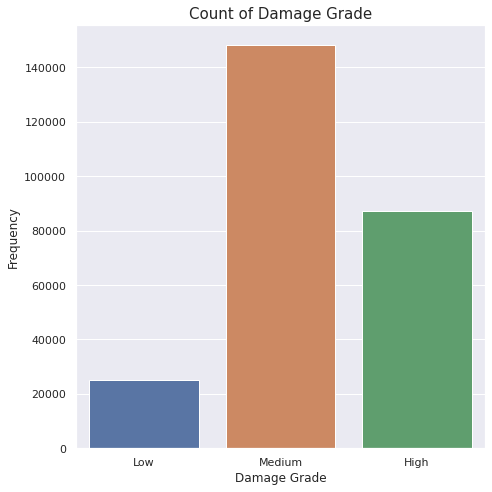

In [22]:
plt.figure(figsize=(7,7))

sns.set_theme()
sns.countplot(train['damage_grade'], order=['Low', 'Medium', 'High'])
plt.xlabel('Damage Grade', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Count of Damage Grade', fontsize=15)
plt.tight_layout()
plt.show()

In [23]:
print('Jumlah Bangunan dengan tingkat kerusakan rendah : {}'.format(sum(train['damage_grade']=='Low')))
print('Jumlah Bangunan dengan tingkat kerusakan menengah : {}'.format(sum(train['damage_grade']=='Medium')))
print('Jumlah Bangunan dengan tingkat kerusakan tinggi : {}'.format(sum(train['damage_grade']=='High')))
print('')
print('Persentase Bangunan dengan tingkat kerusakan rendah : {:.2f}%'.format(sum(train['damage_grade']=='Low')/train.shape[0]*100))
print('Persentase Bangunan dengan tingkat kerusakan menengah : {:.2f}%'.format(sum(train['damage_grade']=='Medium')/train.shape[0]*100))
print('Persentase Bangunan dengan tingkat kerusakan tinggi : {:.2f}%'.format(sum(train['damage_grade']=='High')/train.shape[0]*100))

Jumlah Bangunan dengan tingkat kerusakan rendah : 25124
Jumlah Bangunan dengan tingkat kerusakan menengah : 148259
Jumlah Bangunan dengan tingkat kerusakan tinggi : 87218

Persentase Bangunan dengan tingkat kerusakan rendah : 9.64%
Persentase Bangunan dengan tingkat kerusakan menengah : 56.89%
Persentase Bangunan dengan tingkat kerusakan tinggi : 33.47%


Berdasarkan gambar di atas, terlihat bahwa jumlah bangunan dengan tingkat kerusakan menengah adalah yang paling banyak yaitu sebesar 56.89% diikuti oleh bangunan dengan tingkat kerusakan tinggi sebesar 33.47% dan terakhir bangunan dengan tingkat kerusakan rendah sebesar 9.64%.

### Check Between Feature and Label

#### Geo Level and Damage Grade

In [24]:
def plot_box(data, col_y, y_label, title, col_x = 'damage_grade', x_label = 'Damage Grade'):
    plt.figure(figsize=(7,7))
    sns.set_theme()
    sns.boxplot(data[col_x], data[col_y], order=['Low', 'Medium', 'High'])
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.title(title, fontsize=14)
    plt.show()

**Geo Level 1**

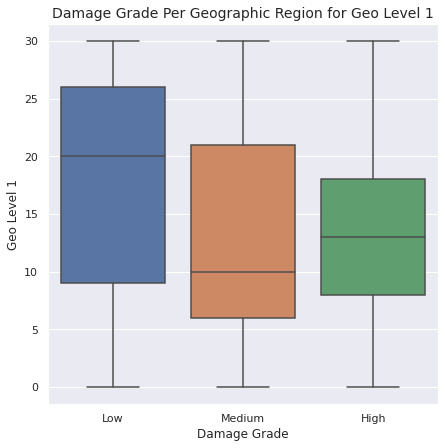

In [25]:
plot_box(train, 'geo_level_1_id', 'Geo Level 1','Damage Grade Per Geographic Region for Geo Level 1')

Berdasarkan gambar di atas, bangunan yang berada pada tingkat geografis level 1 memiliki tingkat kerusakan rendah, menengah, dan tinggi. Pada tingkat geografis 1, sebanyak 75% bangunan yang mengalami tingkat kerusakan rendah berada pada tingkat geografis level 1 pada nilai 9 hingga 26, nilai 6 hingga 21 untuk tingkat kerusakan menengah, dan nilai 8 hingga 18 untuk tingkat kerusakan tinggi. Dikarenakan tingkat geografis level 1 adalah yang paling luas dibandingkan tingkat geografis yang lain, terlihat bahwa bangunan yang berada pada tingkat geografis level 1 pada nilai 8 hingga 18 lebih mengalami kerusakan dibandingkan pada nilai lainnya.

**Geo Level 2**

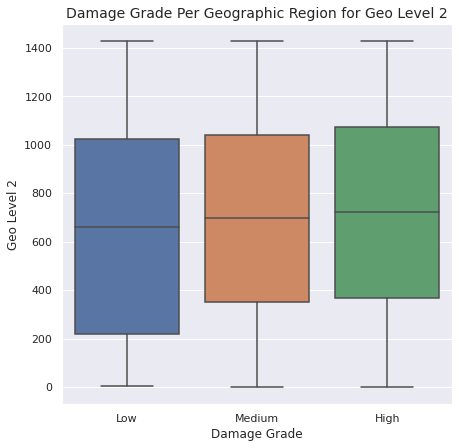

In [26]:
plot_box(train, 'geo_level_2_id', 'Geo Level 2','Damage Grade Per Geographic Region for Geo Level 2')

Berdasarkan gambar di atas, bangunan yang berada pada tingkat geografis level 2 memiliki tingkat kerusakan rendah, menengah, dan tinggi. Pada tingkat geografis 2, sebanyak 75% bangunan yang mengalami tingkat kerusakan rendah berada pada tingkat geografis level 2 pada nilai 200 hingga 1100, nilai 350 hingga 1100 untuk tingkat kerusakan menengah, dan nilai 350 hingga 1100 untuk tingkat kerusakan tinggi. Dikarenakan tingkat geografis level 2 adalah tingkat geografis yang lebih sempit dibandingkan tingkat geografis 1, terlihat bahwa persebaran kerusaan bangunan yang berada pada tingkat geografis level 2 lebih mirip untuk ketiga tingkat kerusakan. 

**Geo Level 3**

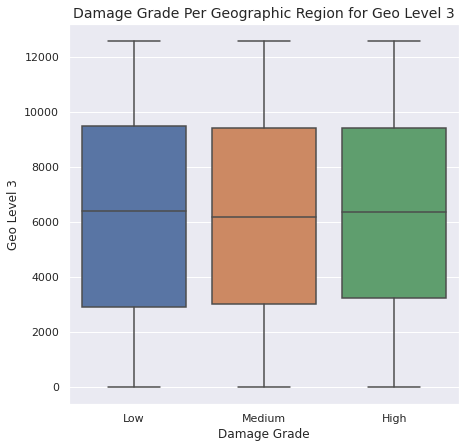

In [27]:
plot_box(train, 'geo_level_3_id', 'Geo Level 3','Damage Grade Per Geographic Region for Geo Level 3')

Berdasarkan gambar di atas, bangunan yang berada pada tingkat geografis level 2 memiliki tingkat kerusakan rendah, menengah, dan tinggi. Dikarenakan tingkat geografis level 3 adalah tingkat geografis yang lebih sempit dibandingkan tingkat geografis lainnya, bangunan pada tingkat geografis 3 memiliki tingkat kerusakan yang hampir sama pada semua nilainya.

#### Number of Floor and Damage Grade

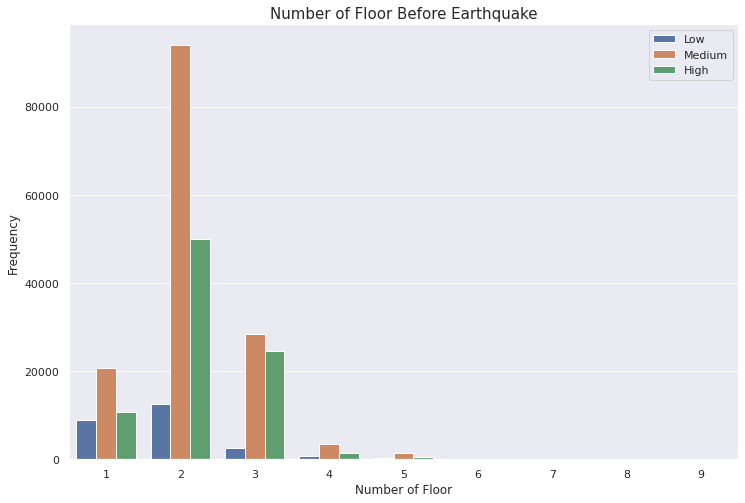

In [28]:
plt.figure(figsize=(12,8))

sns.countplot(train['count_floors_pre_eq'], hue=train['damage_grade'], hue_order=['Low', 'Medium', 'High'])
plt.xlabel('Number of Floor', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Number of Floor Before Earthquake', fontsize=15)
plt.legend(loc='upper right')
plt.show()

Bangunan di Nepal yang mengalami kerusakan akibat gempa mempunyai jumlah lantai yang beragam dimulai dari bangunan dengan 1 lantai hingga 9 lantai. Adapun 3 jenis bangunan berdasarkan jumlah lantainya adalah bangunan 2 lantai, kemudian diikuti dengan 3 lantai dan 1 lantai. Diamati bahwa untuk bangunan yang memiliki 2 lantai mangalami tingkat kerusakan menengah, kemudian diikuti dengan tingkat kerusakan tinggi dan tingkat kerusakan rendah. Hal ini juga berlaku untuk bangunan yang memiliki 3 lantai dan 1 lantai.

#### Age and Damage Grade

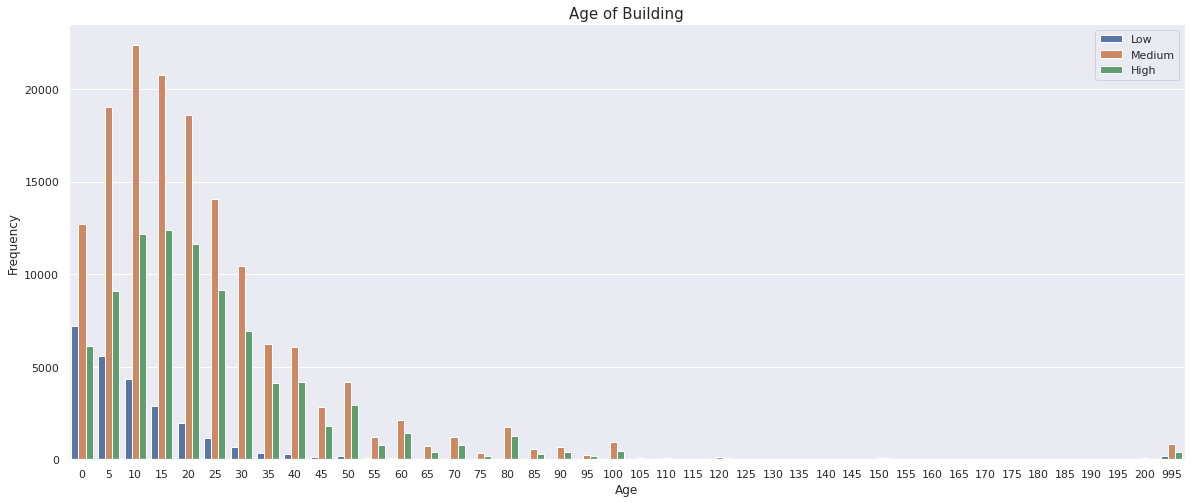

In [29]:
plt.figure(figsize=(20,8))

sns.countplot(train['age'], hue=train['damage_grade'], hue_order=['Low', 'Medium', 'High'])
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Age of Building', fontsize=15)
plt.legend(loc='upper right')
plt.show()

Pada gambar di atas, terlihat bahwa persebaran umur bangunan adalah pada rentang 0-200 tahun kemudian dilanjut dengan umur bangunan lebih dari 950 tahun. Oleh karena itu, akan dibagi plot di atas ke dalam 4 buah segmen yaitu pada range 0-50 tahun, 51-100 tahun, 101-150 tahun, dan lebih dari 150 tahun.

**Segment 1 (0 to 50 years old building)**

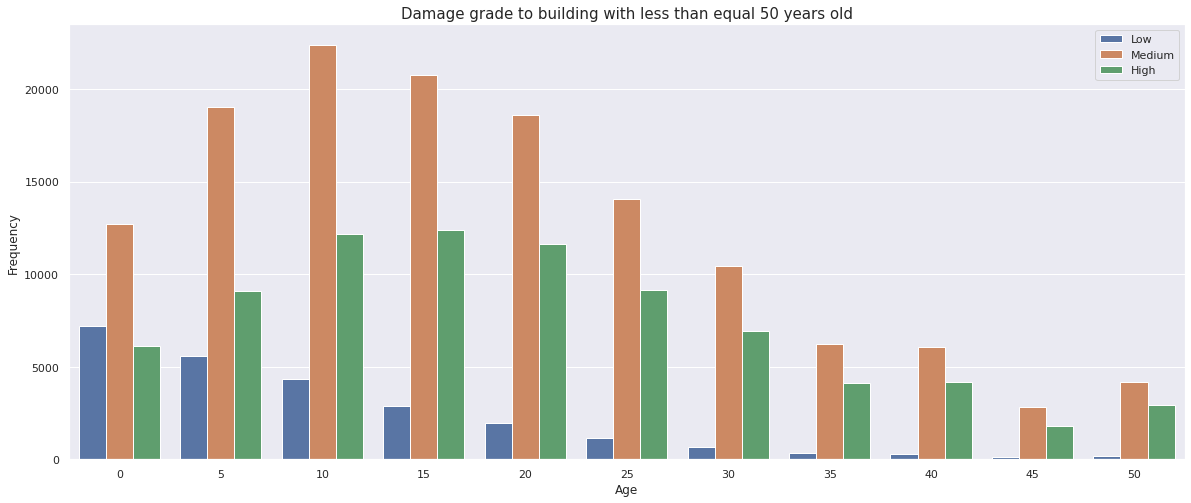

In [30]:
plt.figure(figsize=(20,8))

segment_1_age = train[train['age']<=50]
sns.countplot(segment_1_age['age'], hue=segment_1_age['damage_grade'], hue_order=['Low', 'Medium', 'High'])
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Damage grade to building with less than equal 50 years old', fontsize=15)
plt.legend(loc='upper right')
plt.show()

Berdasarkan gambar di atas, terlihat bahwa pada umur bangunan antara 0 hingga 50 tahun, tingkat kerusakan bangunan paling banyak adalah tingkat kerusakan sedang. Pada umur bangunan antara 0 hingga 40 tahun terlihat bangunan dengan tingkat kerusakan ringan mengalami penurunan.

**Segment 2 (51 to 100 years old building)**

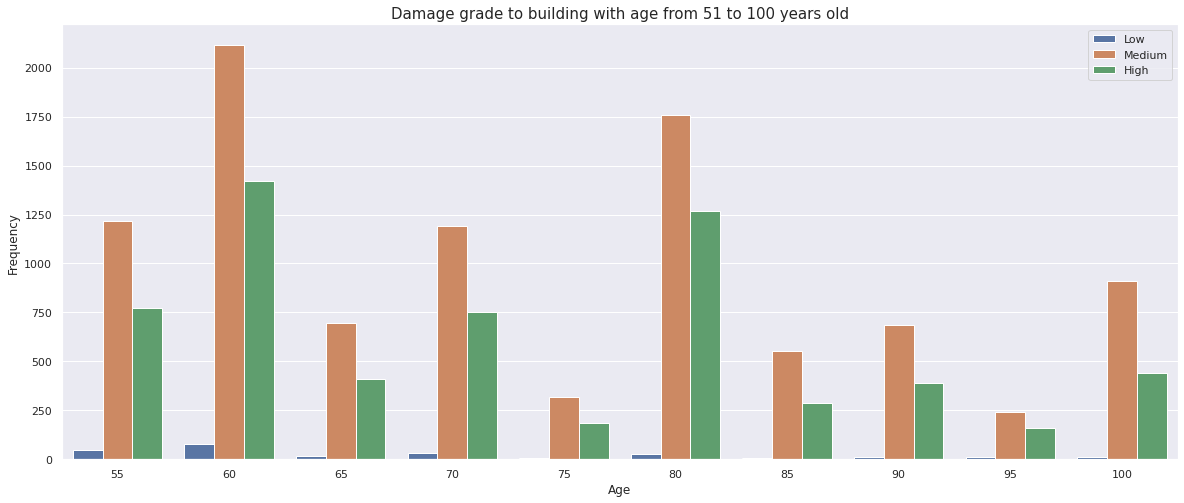

In [31]:
plt.figure(figsize=(20,8))

segment_2_age = train[(train['age']>50) & (train['age']<=100)]
sns.countplot(segment_2_age['age'], hue=segment_2_age['damage_grade'], hue_order=['Low', 'Medium', 'High'])
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Damage grade to building with age from 51 to 100 years old', fontsize=15)
plt.legend(loc='upper right')
plt.show()

Berdasarkan gambar di atas, terlihat bahwa pada umur bangunan antara 51 hingga 100 tahun, tingkat kerusakan bangunan paling banyak adalah tingkat kerusakan sedang. Pada umur bangunan antara 51 hingga 100, hanya ada sedikit bangunan yang mengalami tingkat kerusakan ringan.

**Segment 3 (101 to 150 years old building)**

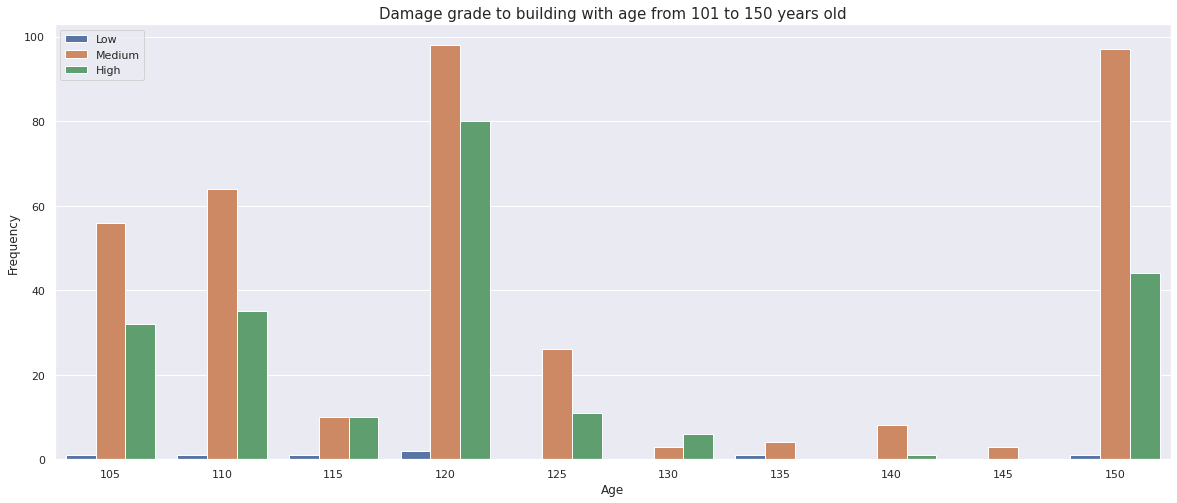

In [32]:
plt.figure(figsize=(20,8))

segment_3_age = train[(train['age']>100) & (train['age']<=150)]
sns.countplot(segment_3_age['age'], hue=segment_3_age['damage_grade'], hue_order=['Low', 'Medium', 'High'])
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Damage grade to building with age from 101 to 150 years old', fontsize=15)
plt.legend(loc='upper left')
plt.show()

Beberapa bangunan yang mempunyai umur antara 101 hingga 150 tahun mengalami tingkat kerusakan yang didominasi tingkat kerusakan mengengah dan tinggi.

**Segment 4 (150 to 1000 years old building)**

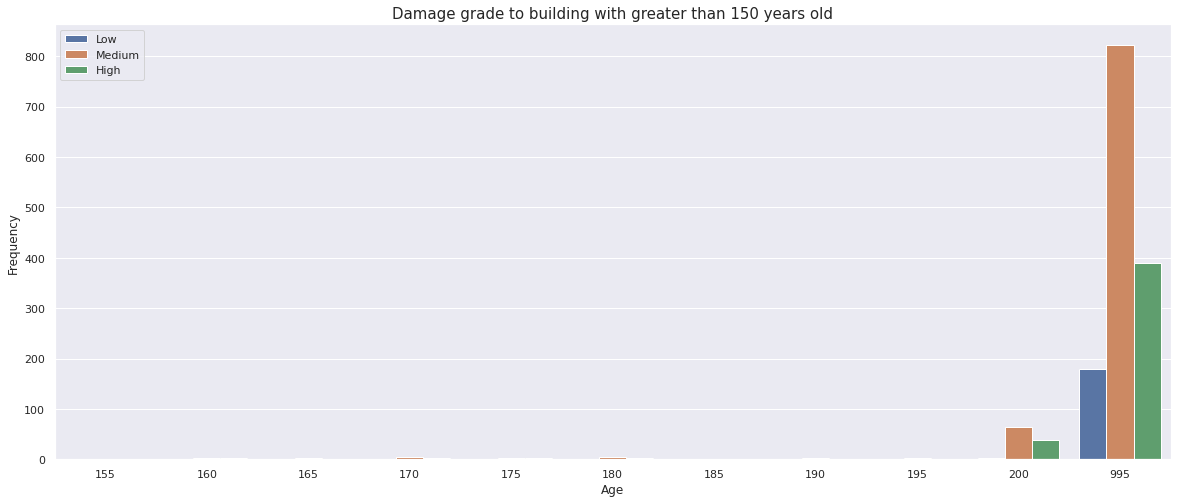

In [33]:
plt.figure(figsize=(20,8))

segment_4_age = train[train['age']>150]
sns.countplot(segment_4_age['age'], hue=segment_4_age['damage_grade'], hue_order=['Low', 'Medium', 'High'])
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Damage grade to building with greater than 150 years old', fontsize=15)
plt.legend(loc='upper left')
plt.show()

Berdasarkan gambar di atas, terdapat bangunan yang mempunyai umur lebih dari 200 tahun dan mengalami tingkat kerusakan baik itu rendah, menengah, dan tinggi. Terdapat bangunan yang mempunyai umur sangat tua yaitu 995 tahun dan banyak diantaranya yang mengalami tingkat kerusakan menengah.

#### Area Percentage and Damage Grade

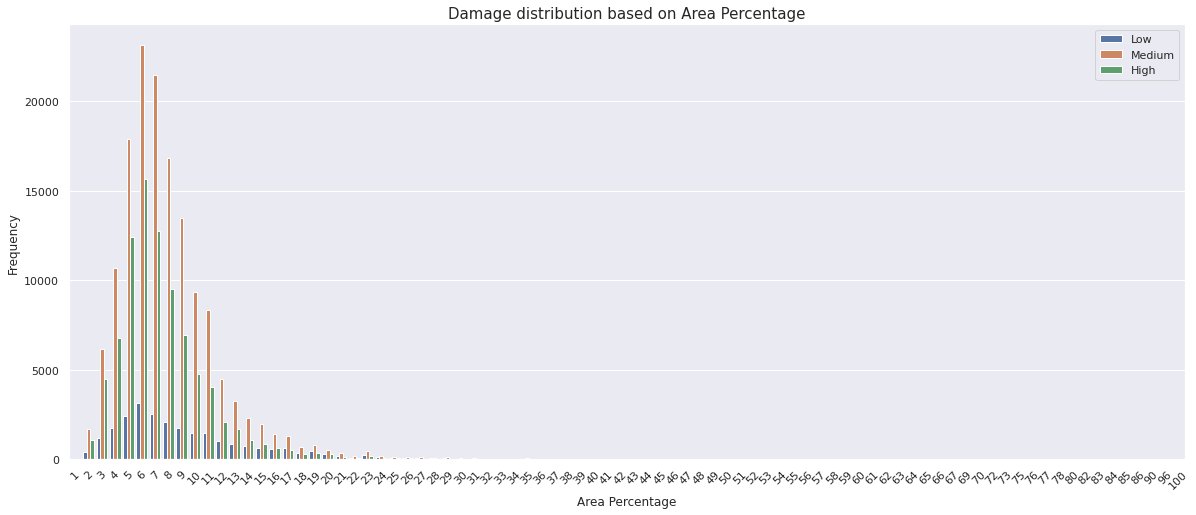

In [34]:
plt.figure(figsize=(20,8))

sns.countplot(train['area_percentage'], hue=train['damage_grade'], hue_order=['Low', 'Medium', 'High'])
plt.xlabel('Area Percentage', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('Frequency', fontsize=12)
plt.title('Damage distribution based on Area Percentage', fontsize=15)
plt.legend(loc='upper right')
plt.show()

Terlihat bahwa banyak bangunan yang ada di Nepal memiliki luas area atau *area percentage* dari 1 hingga 20 $m^2$ dan mayoritas mengalami tingkat kerusakan menengah akibat gempa.

#### Height Percentage and Damage Grade

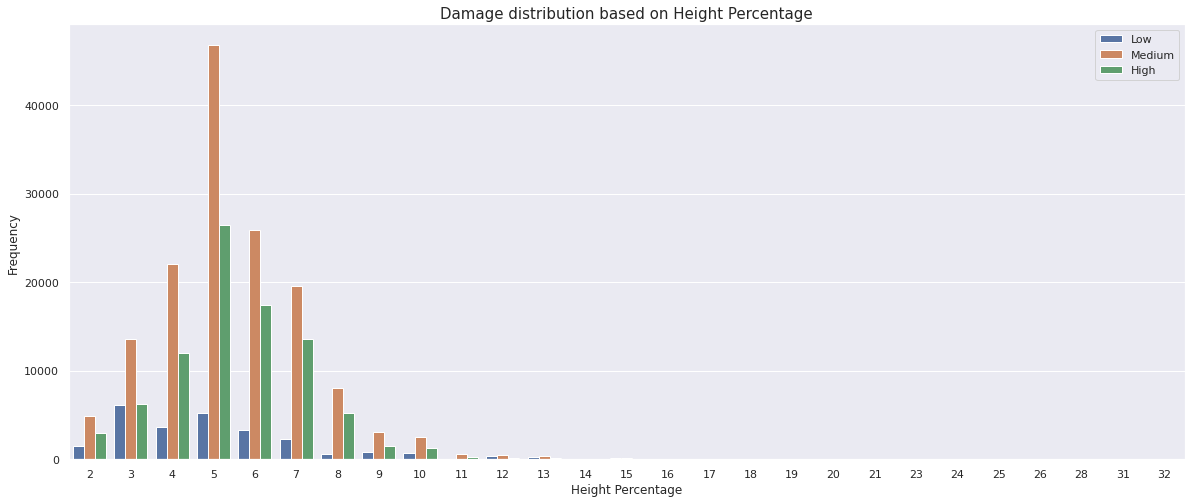

In [35]:
plt.figure(figsize=(20,8))

sns.countplot(train['height_percentage'], hue=train['damage_grade'], hue_order=['Low', 'Medium', 'High'])
plt.xlabel('Height Percentage', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Damage distribution based on Height Percentage', fontsize=15)
plt.legend(loc='upper right')
plt.show()

Untuk tinggi bangunan sendiri berada pada rentang 2 hingga 10 $m$ dan mengalami tingkat kerusakan menengah akibat gempa.

#### Count Families and Damage Grade

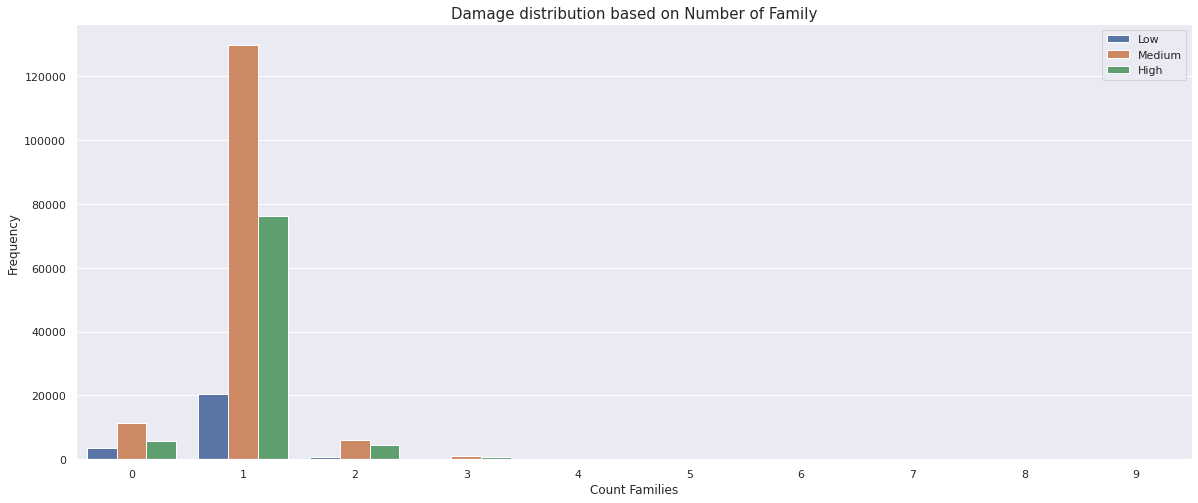

In [36]:
plt.figure(figsize=(20,8))

sns.countplot(train['count_families'], hue=train['damage_grade'], hue_order=['Low', 'Medium', 'High'])
plt.xlabel('Count Families', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Damage distribution based on Number of Family', fontsize=15)
plt.legend(loc='upper right')
plt.show()

Mayoritas bangunan di Nepal yang terkena dampak dari gempa bumi dihuni oleh 0-2 orang. Untuk bangunan dengan 0 orang menyatakan bahwa bangunan tersebut bukanlah bangunan pribadi melainkan fasilitas umum yang tidak ditinggali untuk kehidupan sehari-hari.

#### Land Surface Condition and Damage Grade

In [37]:
def cat_plot(data, col_x, x_label, col_y = 'damage_grade'):
    plt.figure(figsize=(10,4))

    sns.countplot(data[col_x], hue=data[col_y], hue_order=['Low', 'Medium', 'High'])
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Damage distribution based on {}'.format(x_label), fontsize=15)
    plt.legend(loc='upper right')
    plt.show()

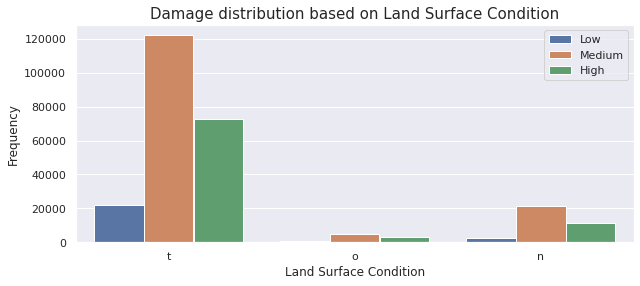

In [38]:
cat_plot(train, 'land_surface_condition', 'Land Surface Condition')

Berdasarkan gambar di atas, bangunan yang ada di nepal mempunyai kondisi permukaan tanah bangunan `t` dan permukaan tanah  ini memiliki pengaruh terhadap tingkat kerusakan yang terjadi pada bangunan.

#### Foundation Type and Damage Grade

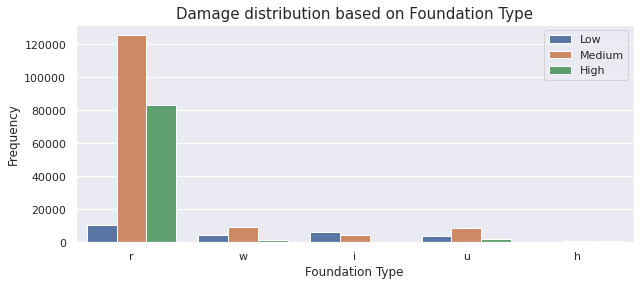

In [39]:
cat_plot(train, 'foundation_type', 'Foundation Type')

Berdasarkan gambar di atas, bangunan dengan tipe pondasi `r` memiliki jumlah terbanyak dan memiliki pengaruh terhadap tingkat kerusakan yang terjadi pada bangunan.

#### Roof Type and Damage Grade

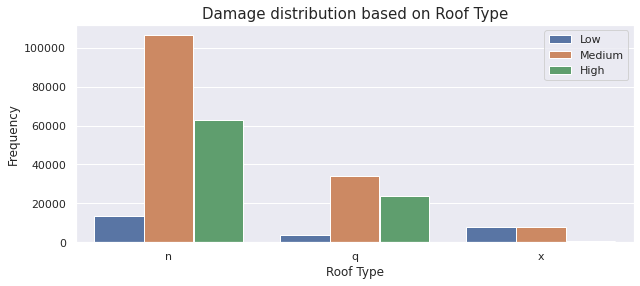

In [40]:
cat_plot(train, 'roof_type', 'Roof Type')

Bangunan dengan jenis atap bangunan bertipe `n` memiliki jumlah terbanyak dan memiliki pengaruh terhadap tingkat kerusakan yang terjadi pada bangunan.

#### Ground Floor Type and Damage Grade

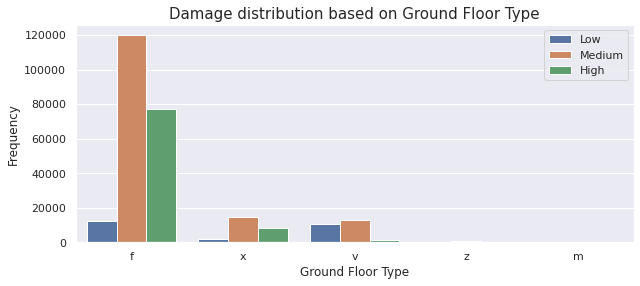

In [41]:
cat_plot(train, 'ground_floor_type', 'Ground Floor Type')

Bangunan dengan jenis lantai yang digunakan pada lantai dasar bangunan bertipe `f` memiliki jumlah terbanyak dan memiliki pengaruh terhadap tingkat kerusakan yang terjadi pada bangunan.

#### Other Floor Type and Damage Grade

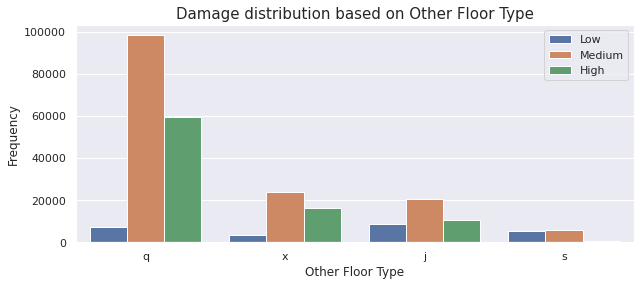

In [42]:
cat_plot(train, 'other_floor_type', 'Other Floor Type')

Bangunan dengan jenis lantai yang digunakan pada lantai lain banyak menggunakan lantai bertipe `q` dan mayoritas diantaranya mengalami tingkat kerusakan menengah dan tinggi.

#### Position and Damage Grade

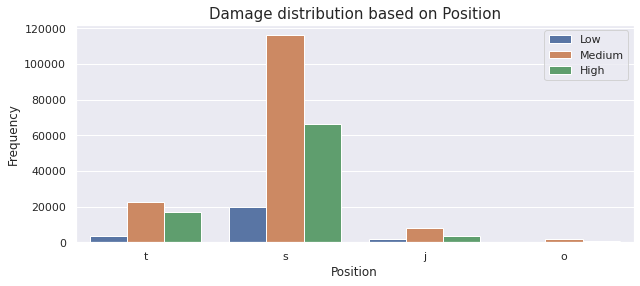

In [43]:
cat_plot(train, 'position', 'Position')

Bangunan yang berada di Nepal kebanyakan menggunakan posisi bertipe `s` dan mayoritas mengalami tingkat kerusakan menengah akibat gempa.

#### Plan Configuration and Damage Grade

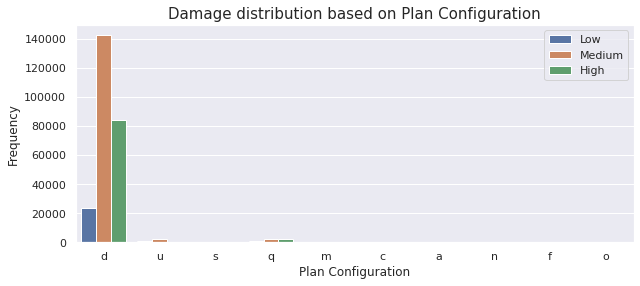

In [44]:
cat_plot(train, 'plan_configuration', 'Plan Configuration')

*Plan configuration* yang ada pada bangunan di Nepal didominasi `d` dan banyak diantaranya yang mengalami tingkat kerusakan menengah.

#### Legal Ownership and Damage Grade

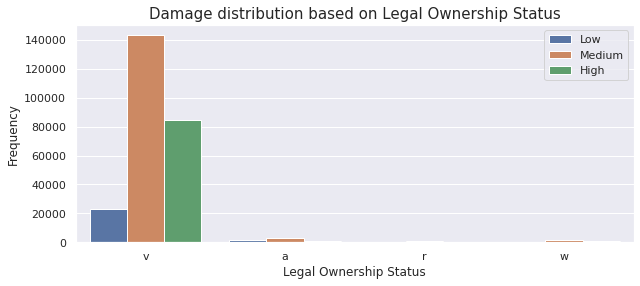

In [45]:
cat_plot(train, 'legal_ownership_status', 'Legal Ownership Status')

Status kepemilikan bangunan didominasi oleh `v` dan banyak diantaranya yang mengalami tingkat kerusakan menengah.

#### Numerical Feature (Binary) and Damage Grade

In [46]:
def count_plot(data, col_x, x_label, title, col_y = 'damage_grade'):
    plt.figure(figsize=(10,4))

    p = sns.countplot(data[col_x], hue=data[col_y], hue_order=['Low', 'Medium', 'High'])
    plt.xlabel(x_label, fontsize=12)
    p.set_xticklabels(['No', 'Yes'])
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Damage distribution that has {}'.format(title), fontsize=15)
    plt.legend(loc='upper right')
    plt.show()

**Has Superstructure Adobe Mud**

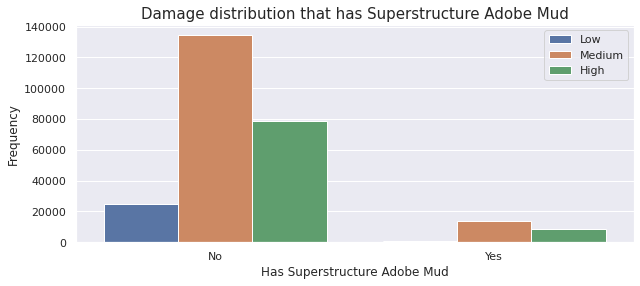

In [47]:
count_plot(train, 'has_superstructure_adobe_mud', 'Has Superstructure Adobe Mud', 'Superstructure Adobe Mud')

**Has Superstructure Mud Mortar Stone**

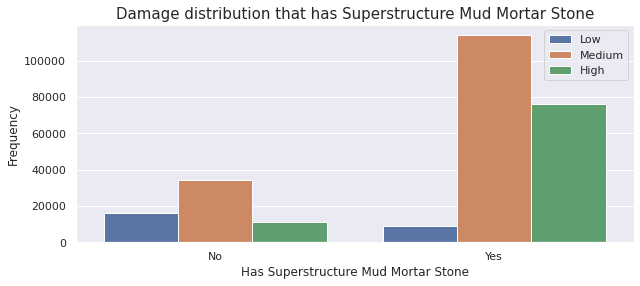

In [48]:
count_plot(train, 'has_superstructure_mud_mortar_stone', 'Has Superstructure Mud Mortar Stone', 'Superstructure Mud Mortar Stone')

**Has Superstructure Stone Flag**

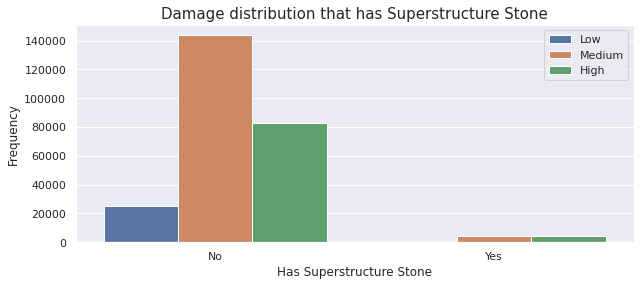

In [49]:
count_plot(train, 'has_superstructure_stone_flag', 'Has Superstructure Stone', 'Superstructure Stone')

**Has Superstructure Cement Mortar Stone**

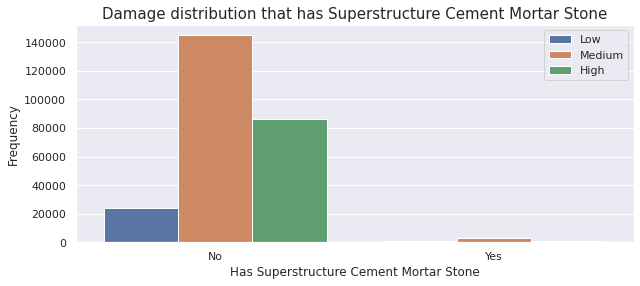

In [50]:
count_plot(train, 'has_superstructure_cement_mortar_stone', 'Has Superstructure Cement Mortar Stone', 'Superstructure Cement Mortar Stone')

**Has Superstructure Mud Mortar Brick**

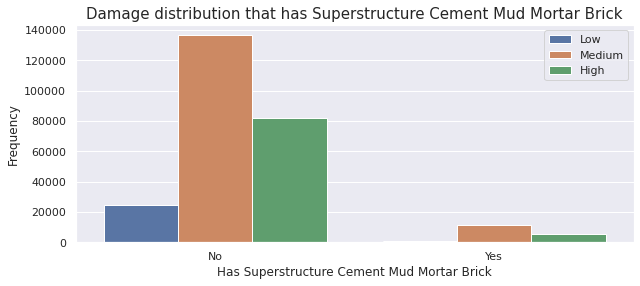

In [51]:
count_plot(train, 'has_superstructure_mud_mortar_brick', 'Has Superstructure Cement Mud Mortar Brick', 'Superstructure Cement Mud Mortar Brick')

**Has Superstructure Cement Mortar Brick**

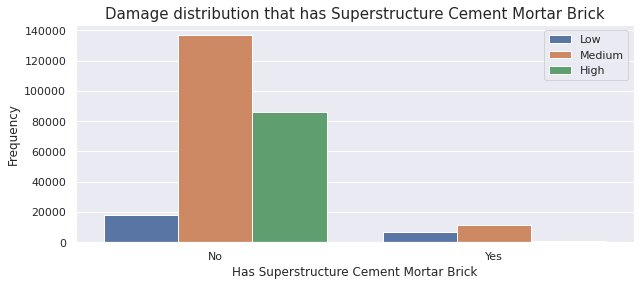

In [52]:
count_plot(train, 'has_superstructure_cement_mortar_brick', 'Has Superstructure Cement Mortar Brick', 'Superstructure Cement Mortar Brick')

**Has Superstructure Timber**

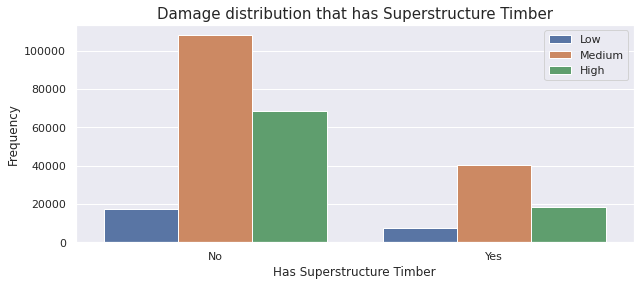

In [53]:
count_plot(train, 'has_superstructure_timber', 'Has Superstructure Timber', 'Superstructure Timber')

**Has Superstructure Bamboo**

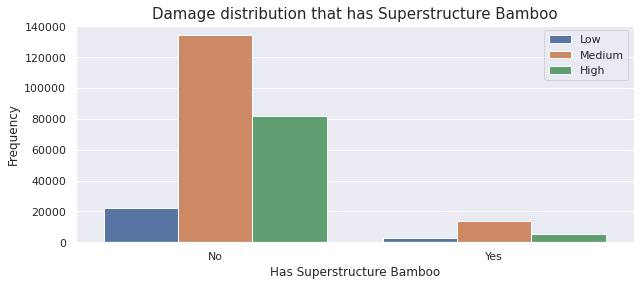

In [54]:
count_plot(train, 'has_superstructure_bamboo', 'Has Superstructure Bamboo', 'Superstructure Bamboo')

**Has Superstructure RC Non Engineered**

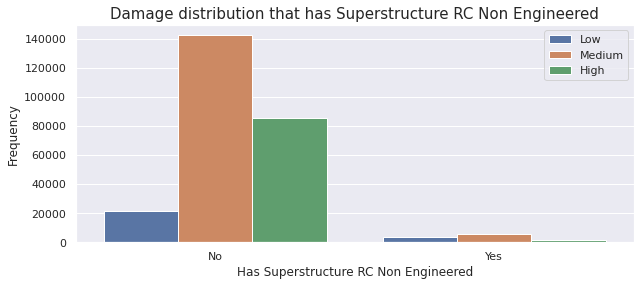

In [55]:
count_plot(train, 'has_superstructure_rc_non_engineered', 'Has Superstructure RC Non Engineered', 'Superstructure RC Non Engineered')

**Has Superstructure RC Engineered**

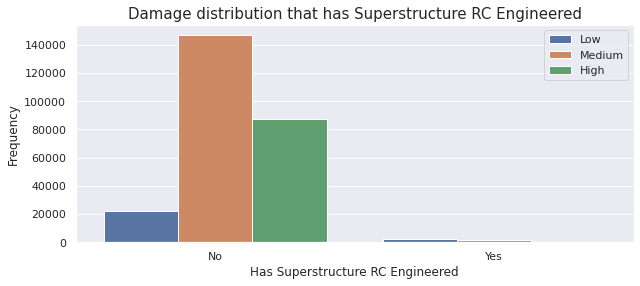

In [56]:
count_plot(train, 'has_superstructure_rc_engineered', 'Has Superstructure RC Engineered', 'Superstructure RC Engineered')

**Has Superstructure Other**

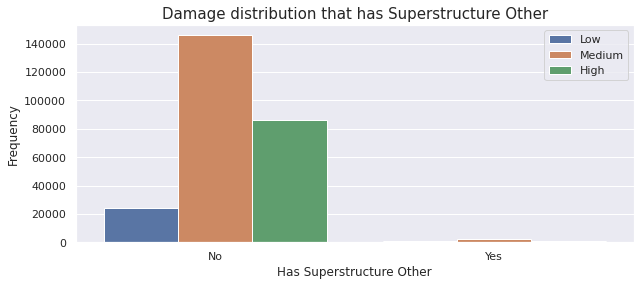

In [57]:
count_plot(train, 'has_superstructure_other', 'Has Superstructure Other', 'Superstructure Other')

Pada bangunan yang ada di Nepal, superstruktur yang banyak digunakan pada bangunan adalah superstruktur campuran antara *Mud Mortar Stone* atau superstruktur dari *Timber*. Pada bangunan yang menggunakan superstruktur tersebut kebanyakan mengalami tingkat kerusakan menengah kemudian disusul dengna tingkat kerusakan tinggi.

**Has Secondary Use**

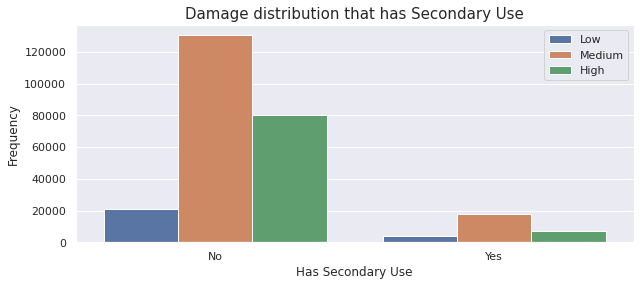

In [58]:
count_plot(train, 'has_secondary_use', 'Has Secondary Use', 'Secondary Use')

**Has Secondary Use Agriculture**

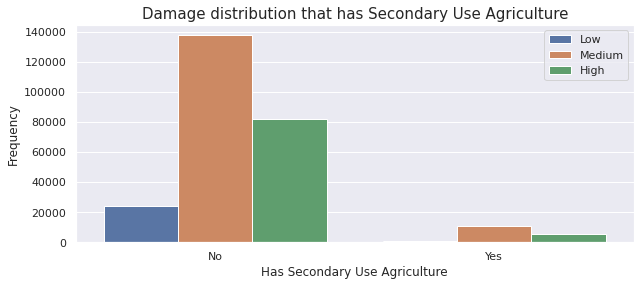

In [59]:
count_plot(train, 'has_secondary_use_agriculture', 'Has Secondary Use Agriculture', 'Secondary Use Agriculture')

**Has Secondary Use Hotel**

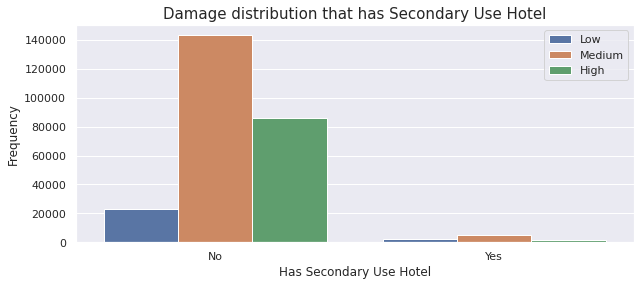

In [60]:
count_plot(train, 'has_secondary_use_hotel', 'Has Secondary Use Hotel', 'Secondary Use Hotel')

**Has Secondary Use Rental**

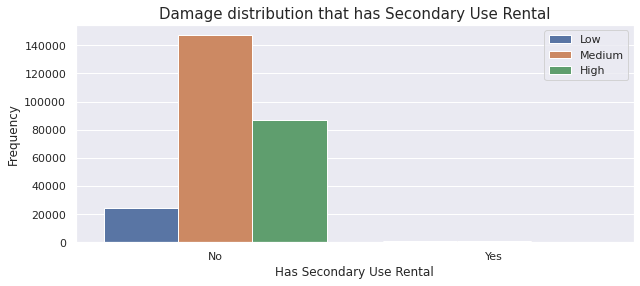

In [61]:
count_plot(train, 'has_secondary_use_rental', 'Has Secondary Use Rental', 'Secondary Use Rental')

**Has Secondary Use Institution**

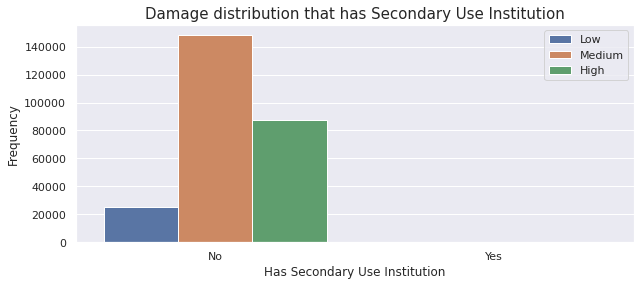

In [62]:
count_plot(train, 'has_secondary_use_institution', 'Has Secondary Use Institution', 'Secondary Use Institution')

**Has Secondary Use School**

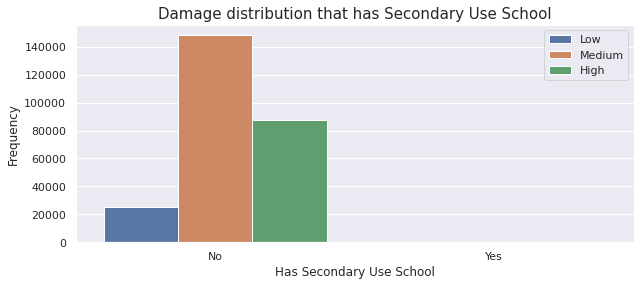

In [63]:
count_plot(train, 'has_secondary_use_school', 'Has Secondary Use School', 'Secondary Use School')

**Has Secondary User Industry**

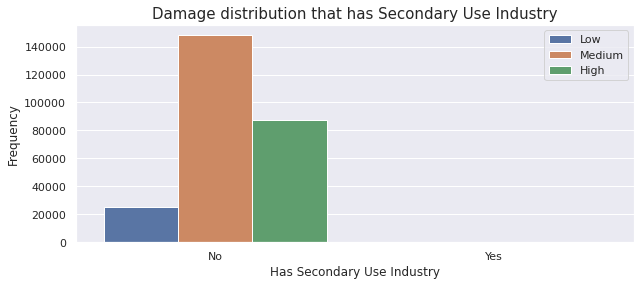

In [64]:
count_plot(train, 'has_secondary_use_industry', 'Has Secondary Use Industry', 'Secondary Use Industry')

**Has Secondary Use Health Post**

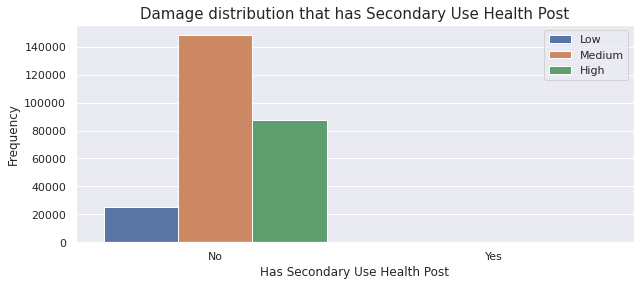

In [65]:
count_plot(train, 'has_secondary_use_health_post', 'Has Secondary Use Health Post', 'Secondary Use Health Post')

**Has Secondary Use Goverment Office**

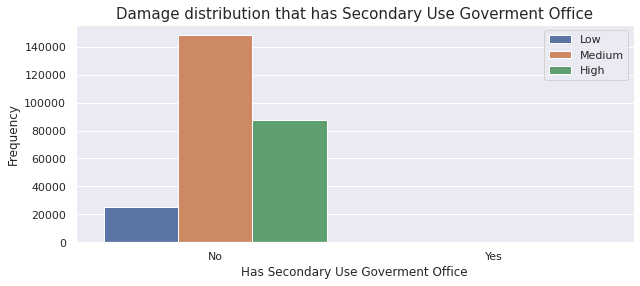

In [66]:
count_plot(train, 'has_secondary_use_gov_office', 'Has Secondary Use Goverment Office', 'Secondary Use Goverment Office')

**Has Secondary Use Police**

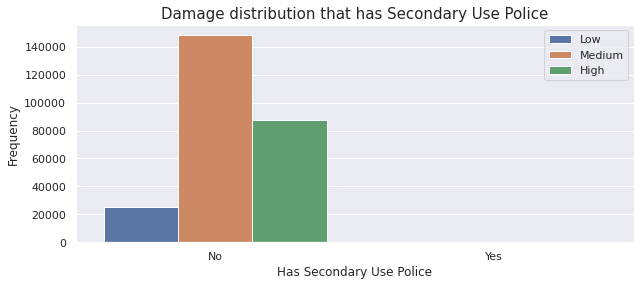

In [67]:
count_plot(train, 'has_secondary_use_use_police', 'Has Secondary Use Police', 'Secondary Use Police')

**Has Secondary Use Other**

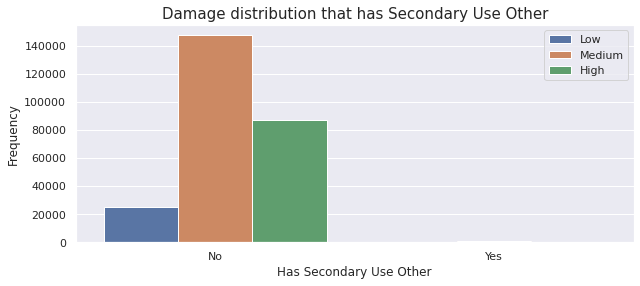

In [68]:
count_plot(train, 'has_secondary_use_other', 'Has Secondary Use Other', 'Secondary Use Other')

Selain bangunan untuk tujuan pribadi, banyak bangunan di Nepal yang digunakan untuk tujuan pertanian, hotel, penyewaan, institusi, sekolah, pos kesehatan, kantor pemerintahan, kantor polisi, dan tujuan lainnya. Bangunan yang mempunyai tujuan sekunder sebagai sarana pertanian dan hotel merupakan dua sektor dengan jumlah bangunan terbanyak dibandingkan dengan bangunan dengan tujuan sekunder lain. Kebanyakan bangunan dengan tujuan sekunder pertanian dan hotel mengalami tingkat kerusakan menengah.

### Facetgrid

In [69]:
def facet_plot(data, col, x, x_label):
    grid = sns.FacetGrid(data, col=col, row='damage_grade', size=4, aspect=2, sharey=False)
    grid.map(plt.hist, x, bins=20)
    grid.set_xlabels(x_label)
    grid.set_ylabels('Frequency')
    plt.show()

#### Superstructure RC, non RC, Mud Mortar Stone, Mud Mortar Brick, Cement Mortar Brick and Number of Floor

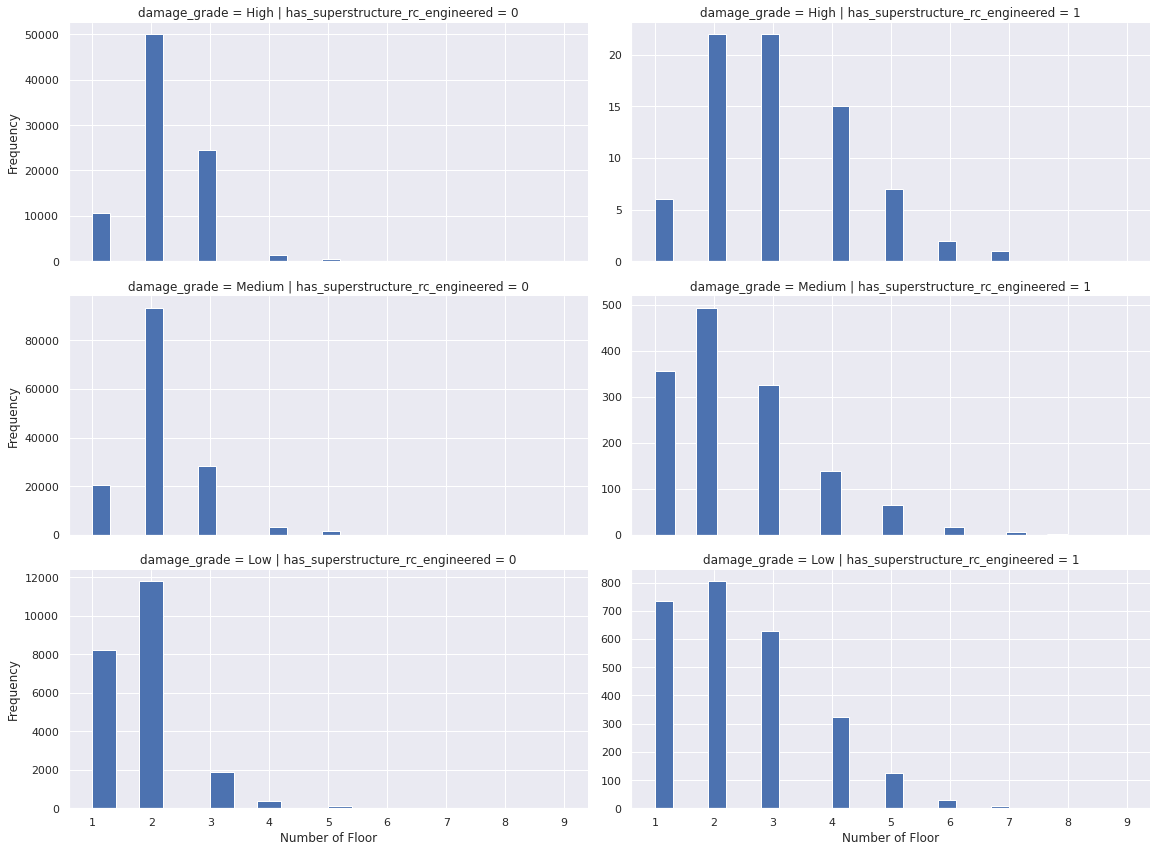

In [70]:
facet_plot(train, 'has_superstructure_rc_engineered', 'count_floors_pre_eq', 'Number of Floor')

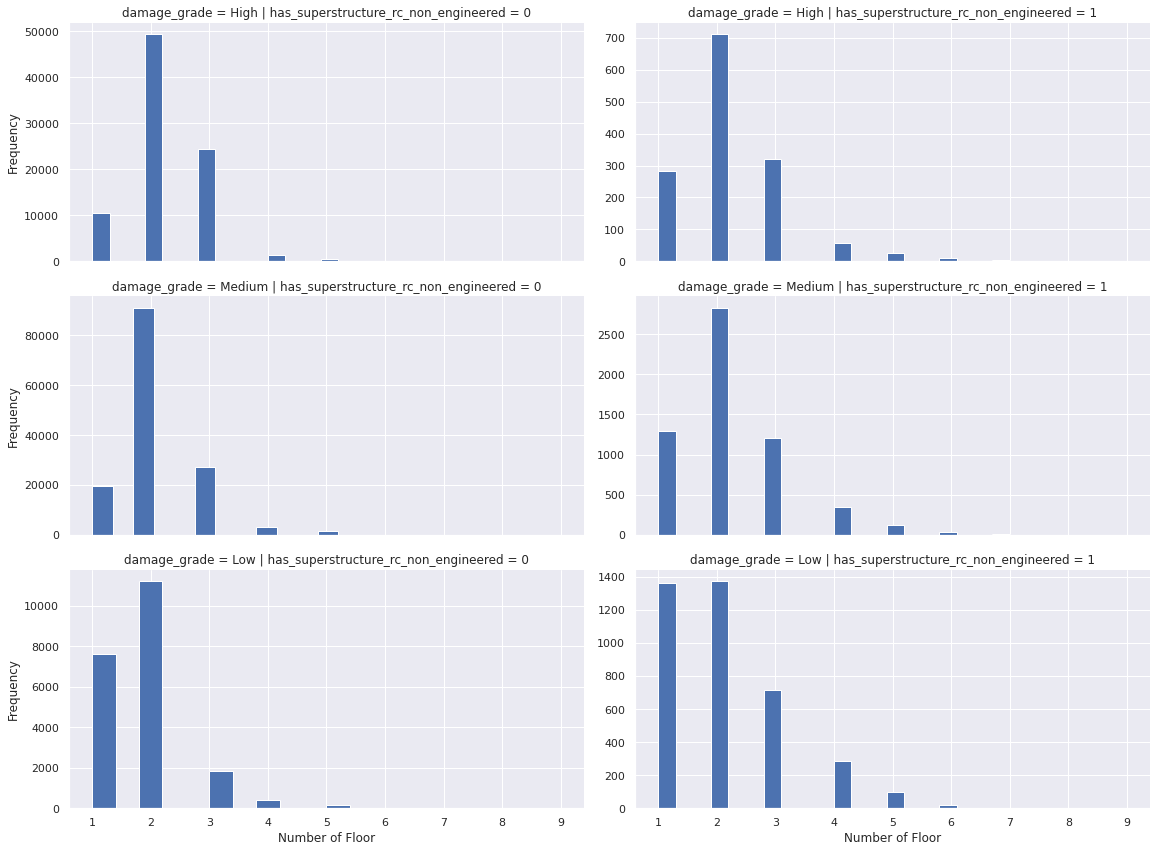

In [71]:
facet_plot(train, 'has_superstructure_rc_non_engineered', 'count_floors_pre_eq', 'Number of Floor')

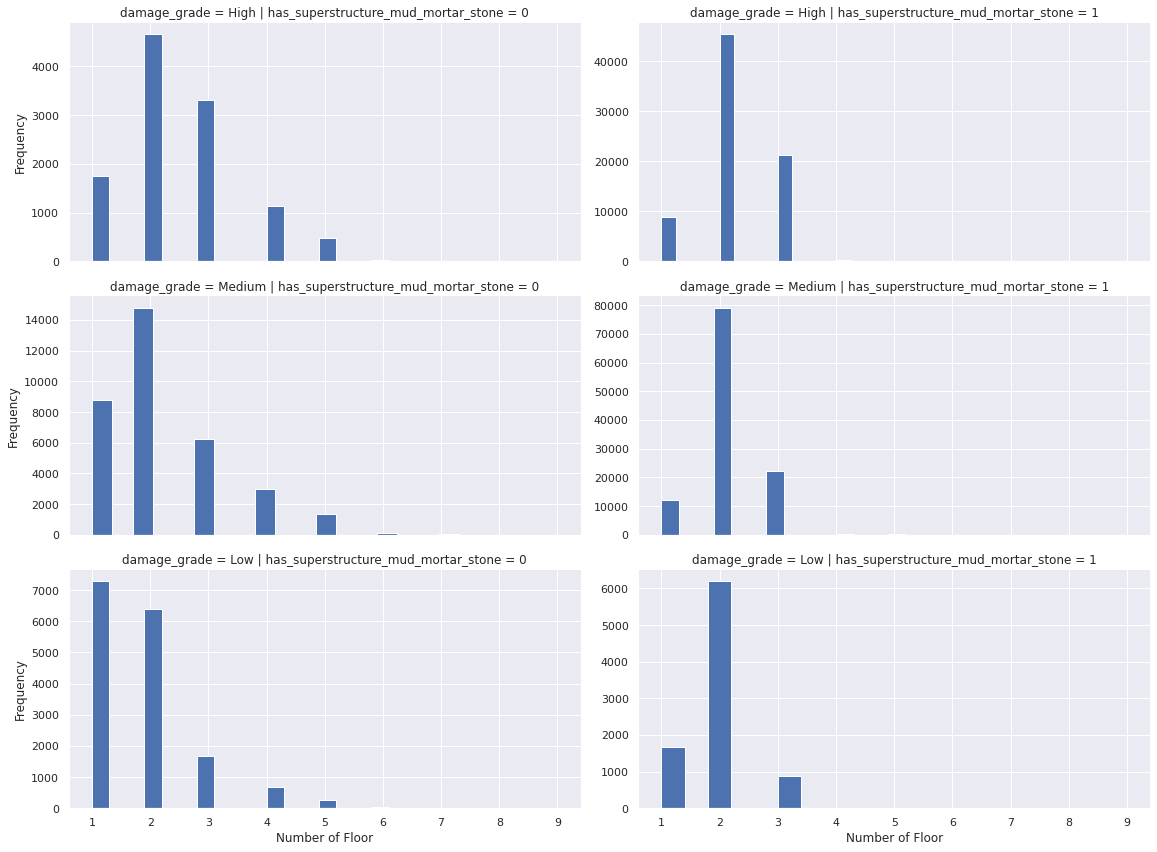

In [72]:
facet_plot(train, 'has_superstructure_mud_mortar_stone', 'count_floors_pre_eq', 'Number of Floor')

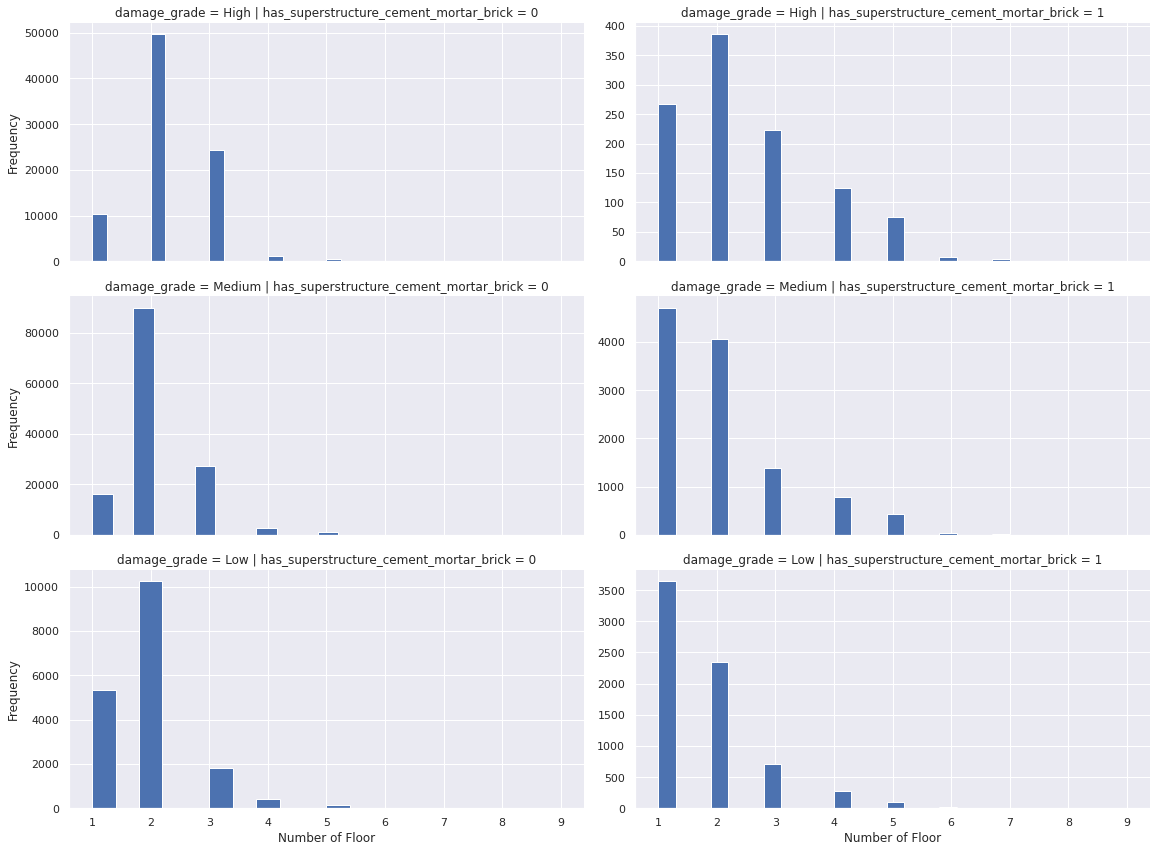

In [73]:
facet_plot(train, 'has_superstructure_cement_mortar_brick', 'count_floors_pre_eq', 'Number of Floor')

#### Superstructure RC, non RC, Mud Mortar Stone, Mud Mortar Brick, Cement Mortar Brick and Height Percentage

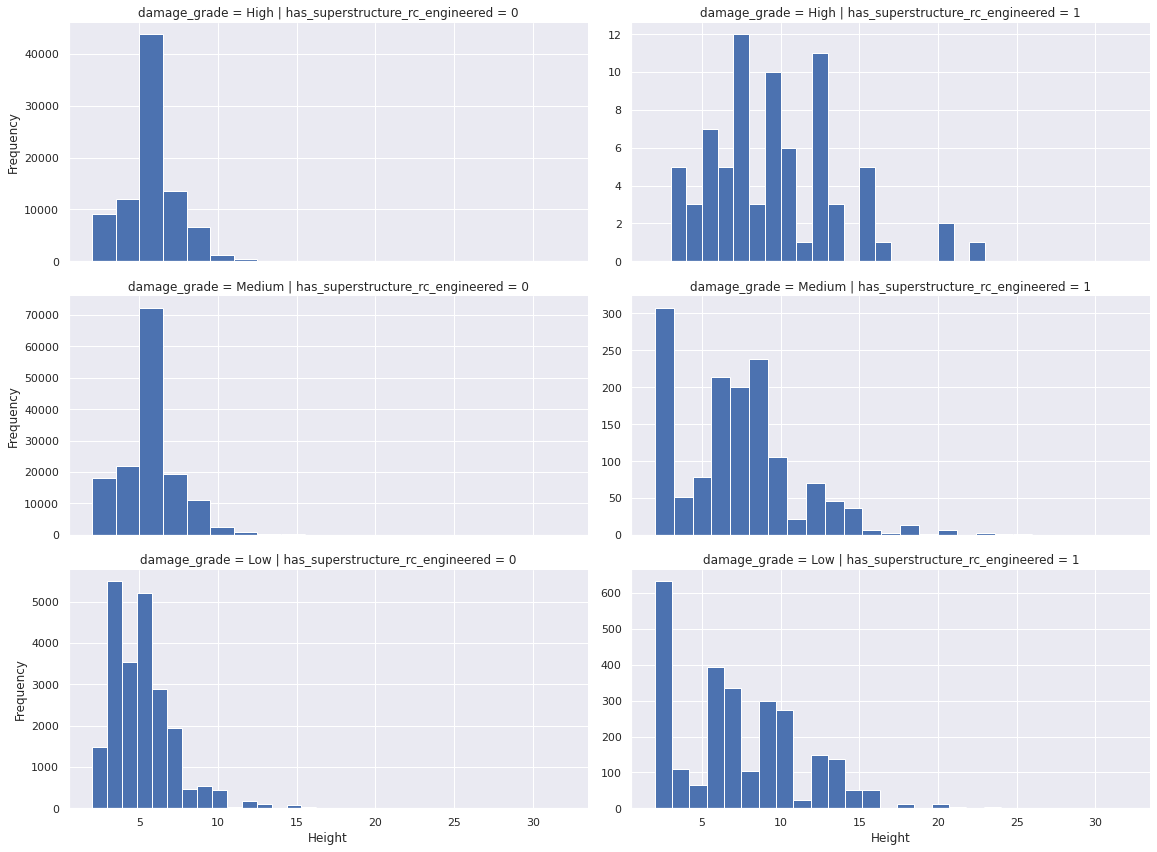

In [74]:
facet_plot(train, 'has_superstructure_rc_engineered', 'height_percentage', 'Height')

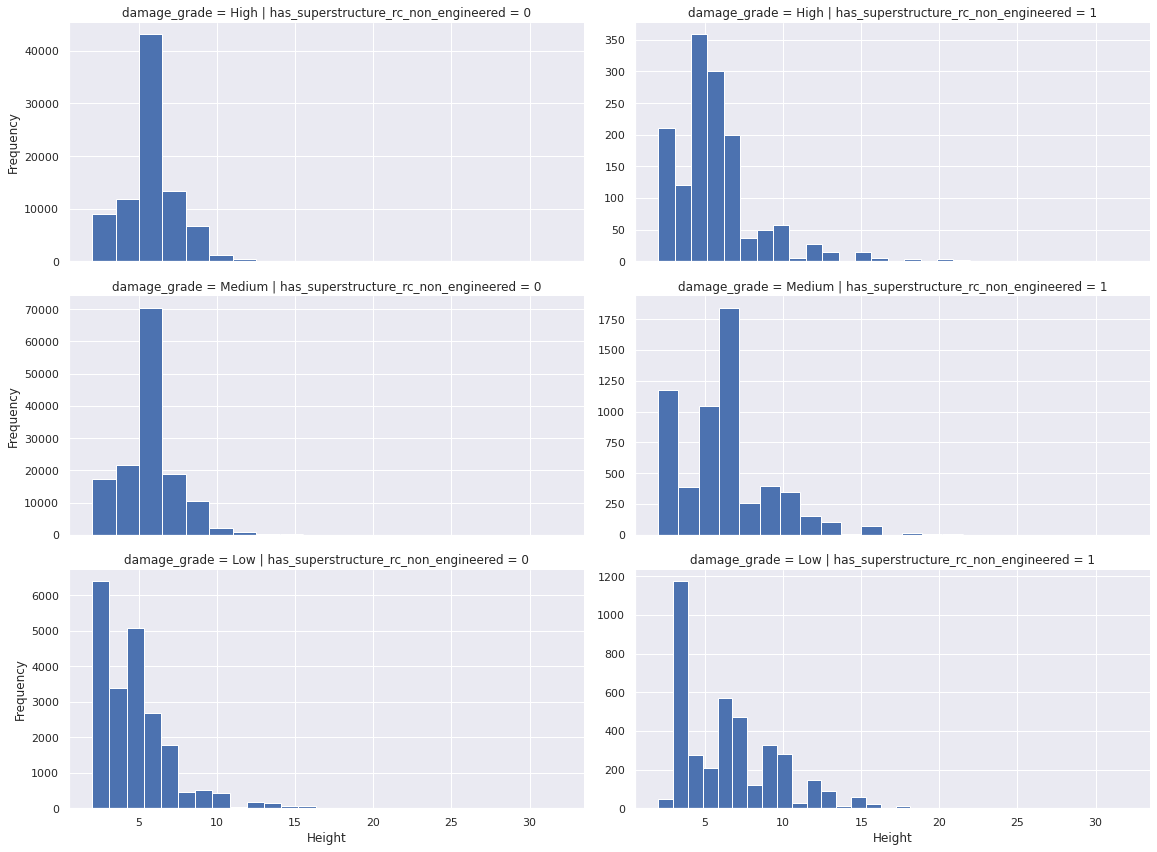

In [75]:
facet_plot(train, 'has_superstructure_rc_non_engineered', 'height_percentage', 'Height')

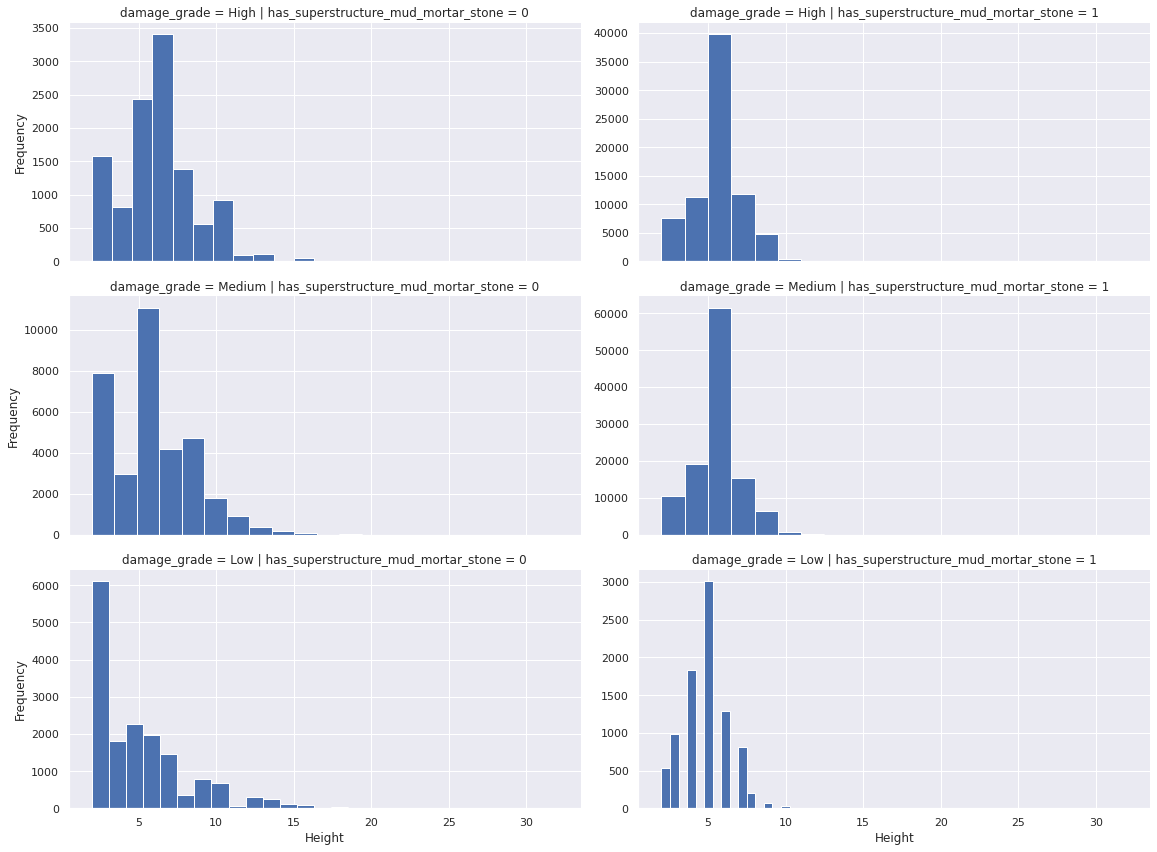

In [76]:
facet_plot(train, 'has_superstructure_mud_mortar_stone', 'height_percentage', 'Height')

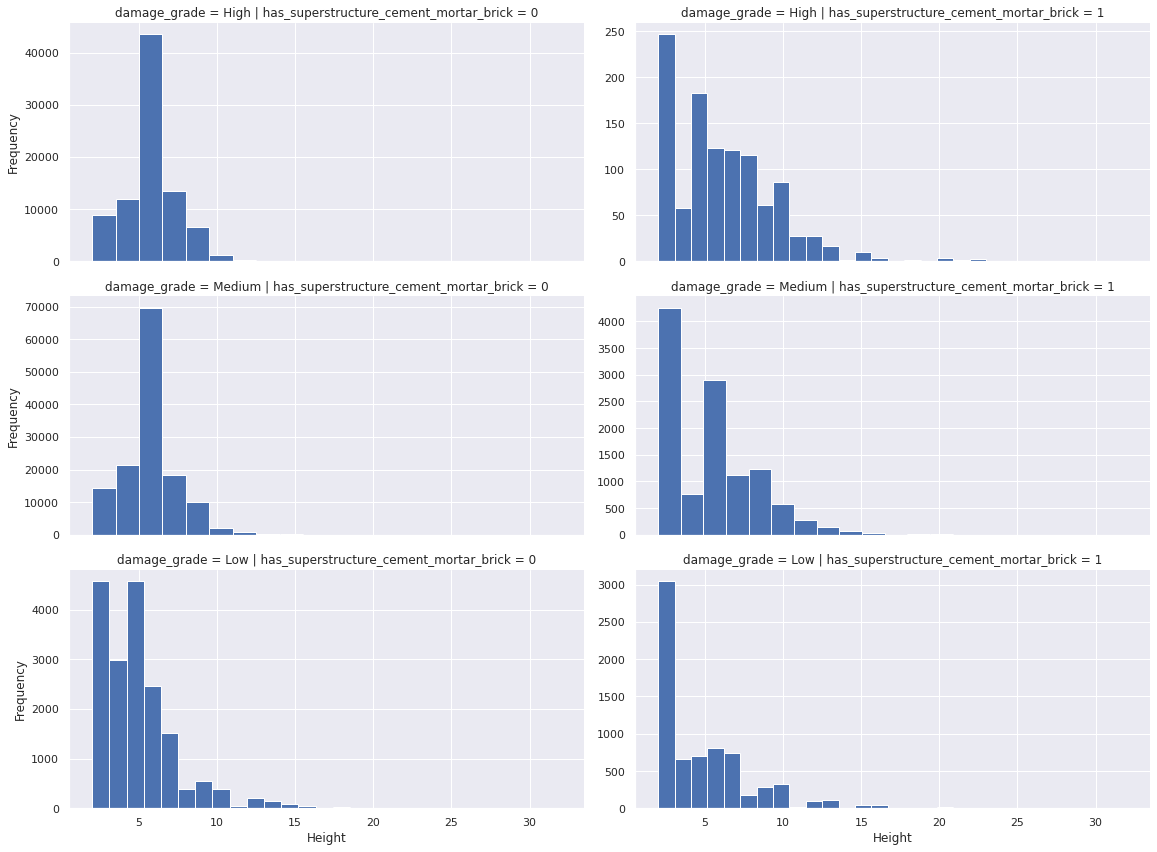

In [77]:
facet_plot(train, 'has_superstructure_cement_mortar_brick', 'height_percentage', 'Height')

#### Superstructure RC, non RC, Mud Mortar Stone, Mud Mortar Brick, Cement Mortar Brick and Area Percentage

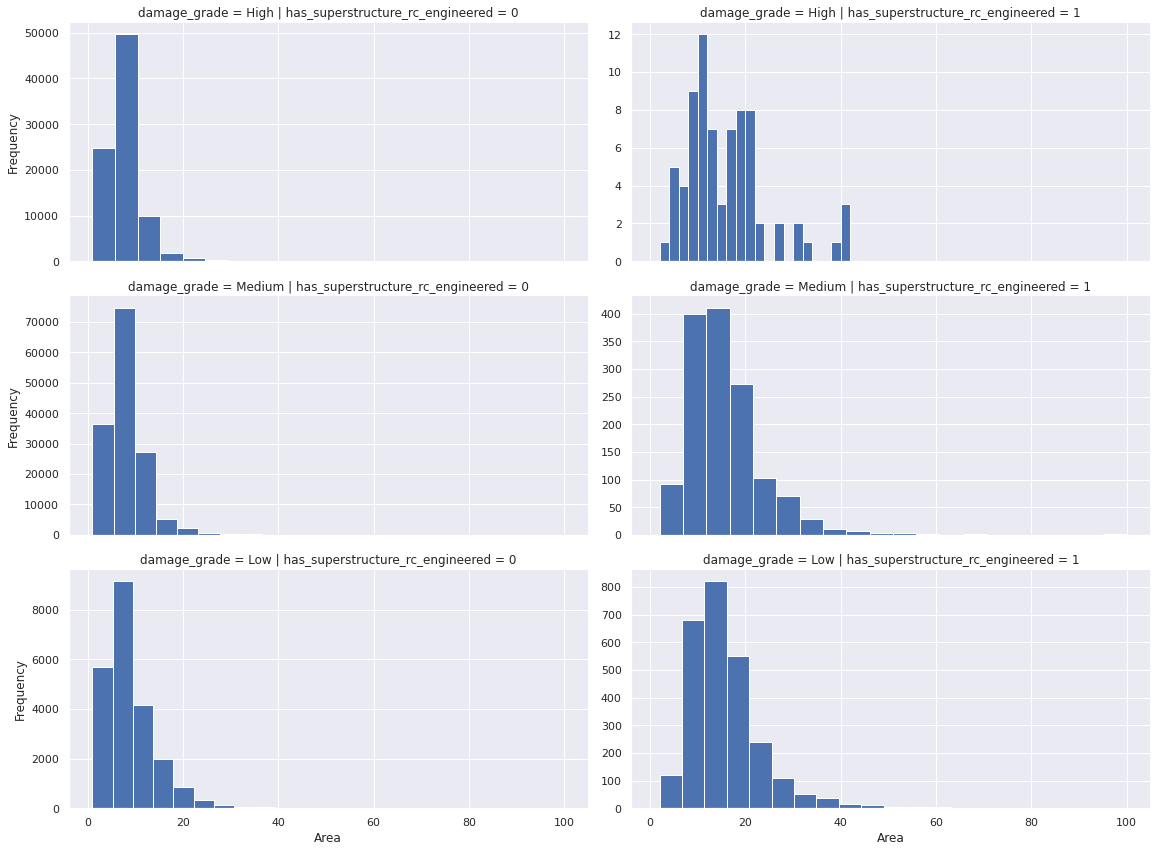

In [78]:
facet_plot(train, 'has_superstructure_rc_engineered', 'area_percentage', 'Area')

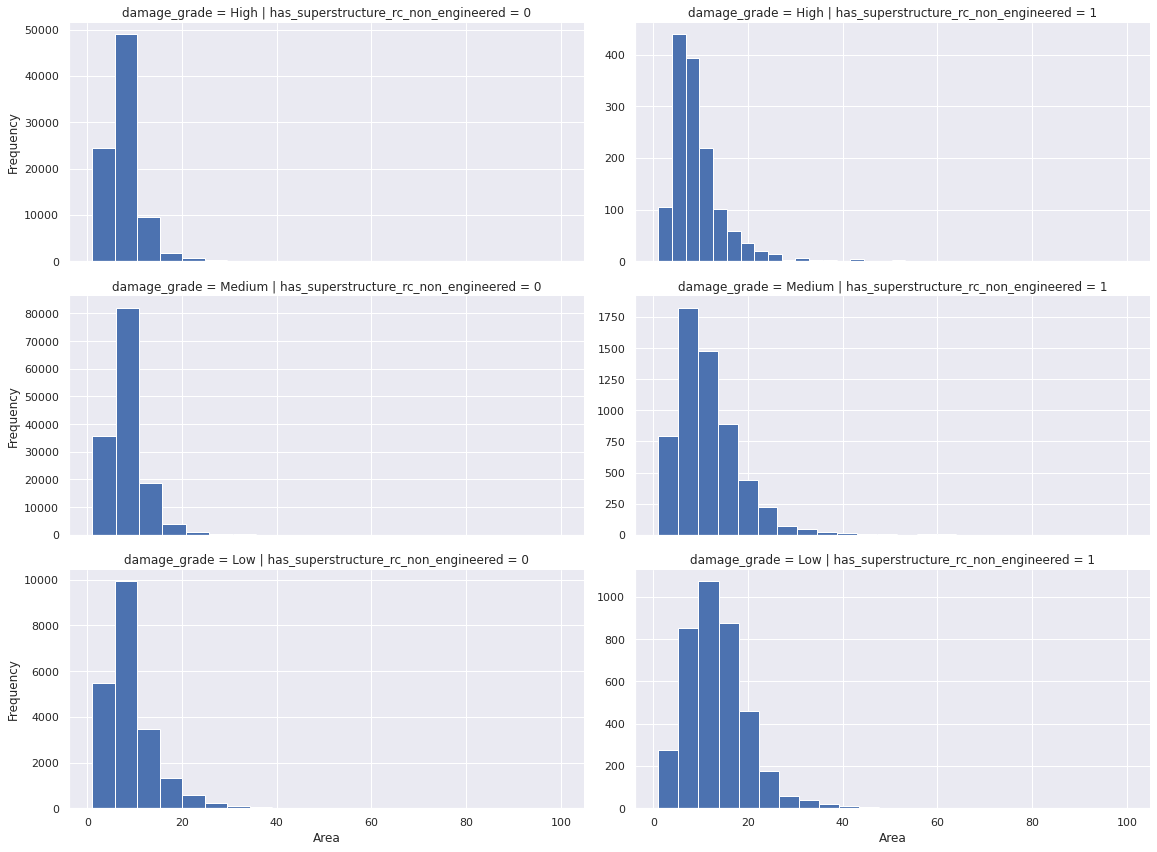

In [79]:
facet_plot(train, 'has_superstructure_rc_non_engineered', 'area_percentage', 'Area')

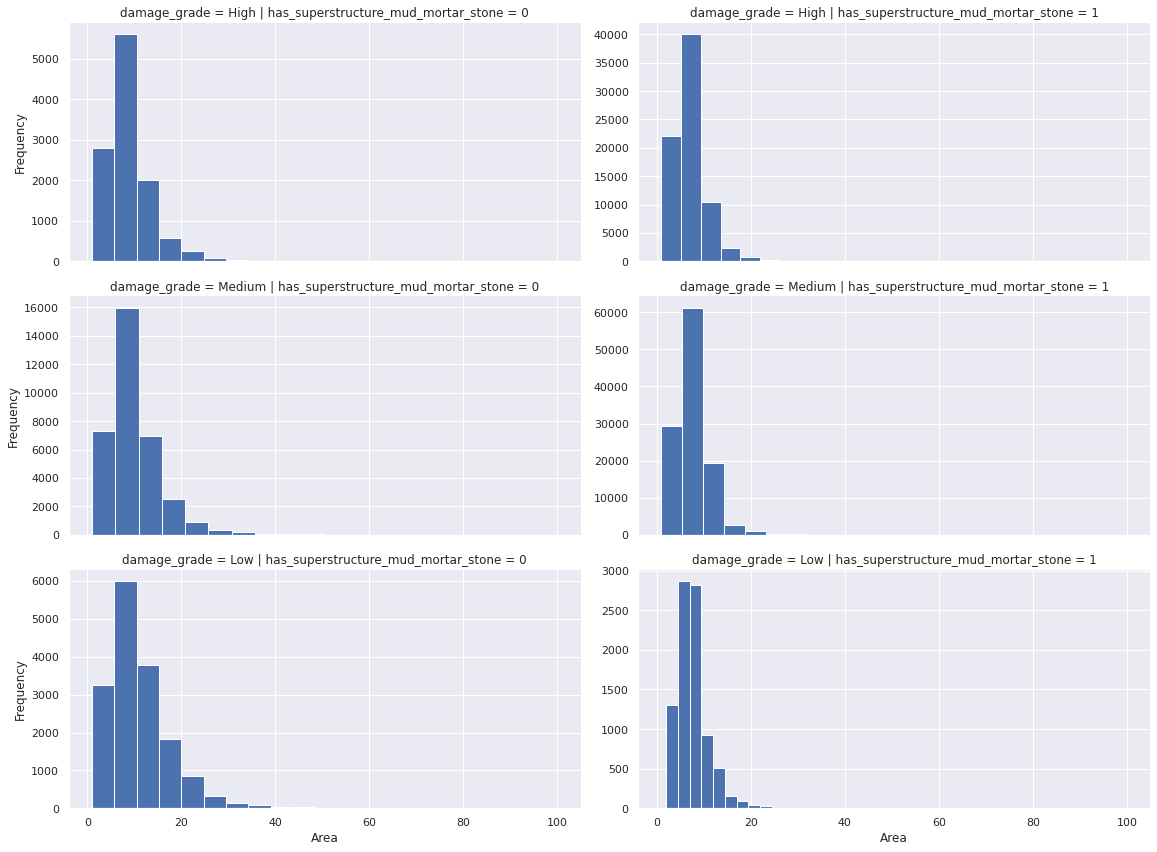

In [80]:
facet_plot(train, 'has_superstructure_mud_mortar_stone', 'area_percentage', 'Area')

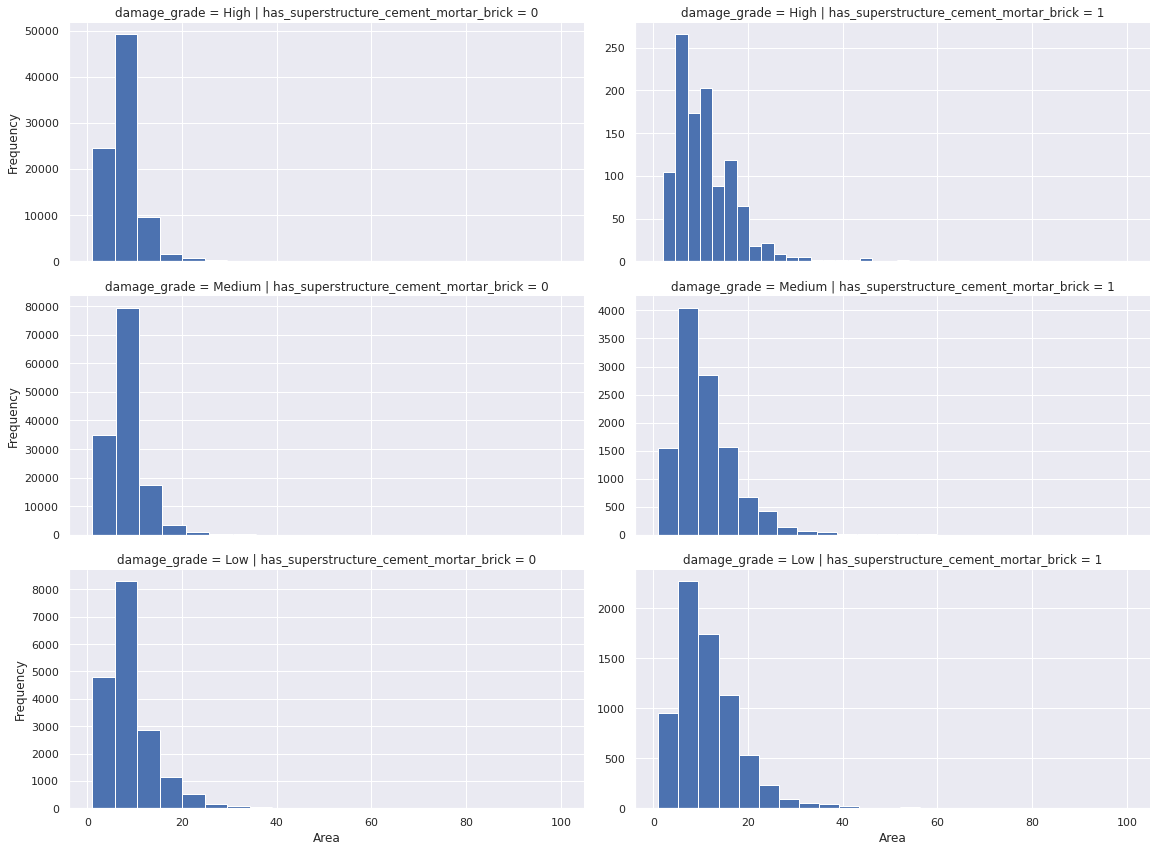

In [81]:
facet_plot(train, 'has_superstructure_cement_mortar_brick', 'area_percentage', 'Area')

### Multivariate Analysis

In [82]:
features = train.copy()
features['damage_grade'] = features['damage_grade'].replace({'Low':1, 'Medium':2, 'High':3})
features['damage_grade'] = features['damage_grade'].astype('int64')
corr_matrix = features.corr()

#### Correlation Matrix

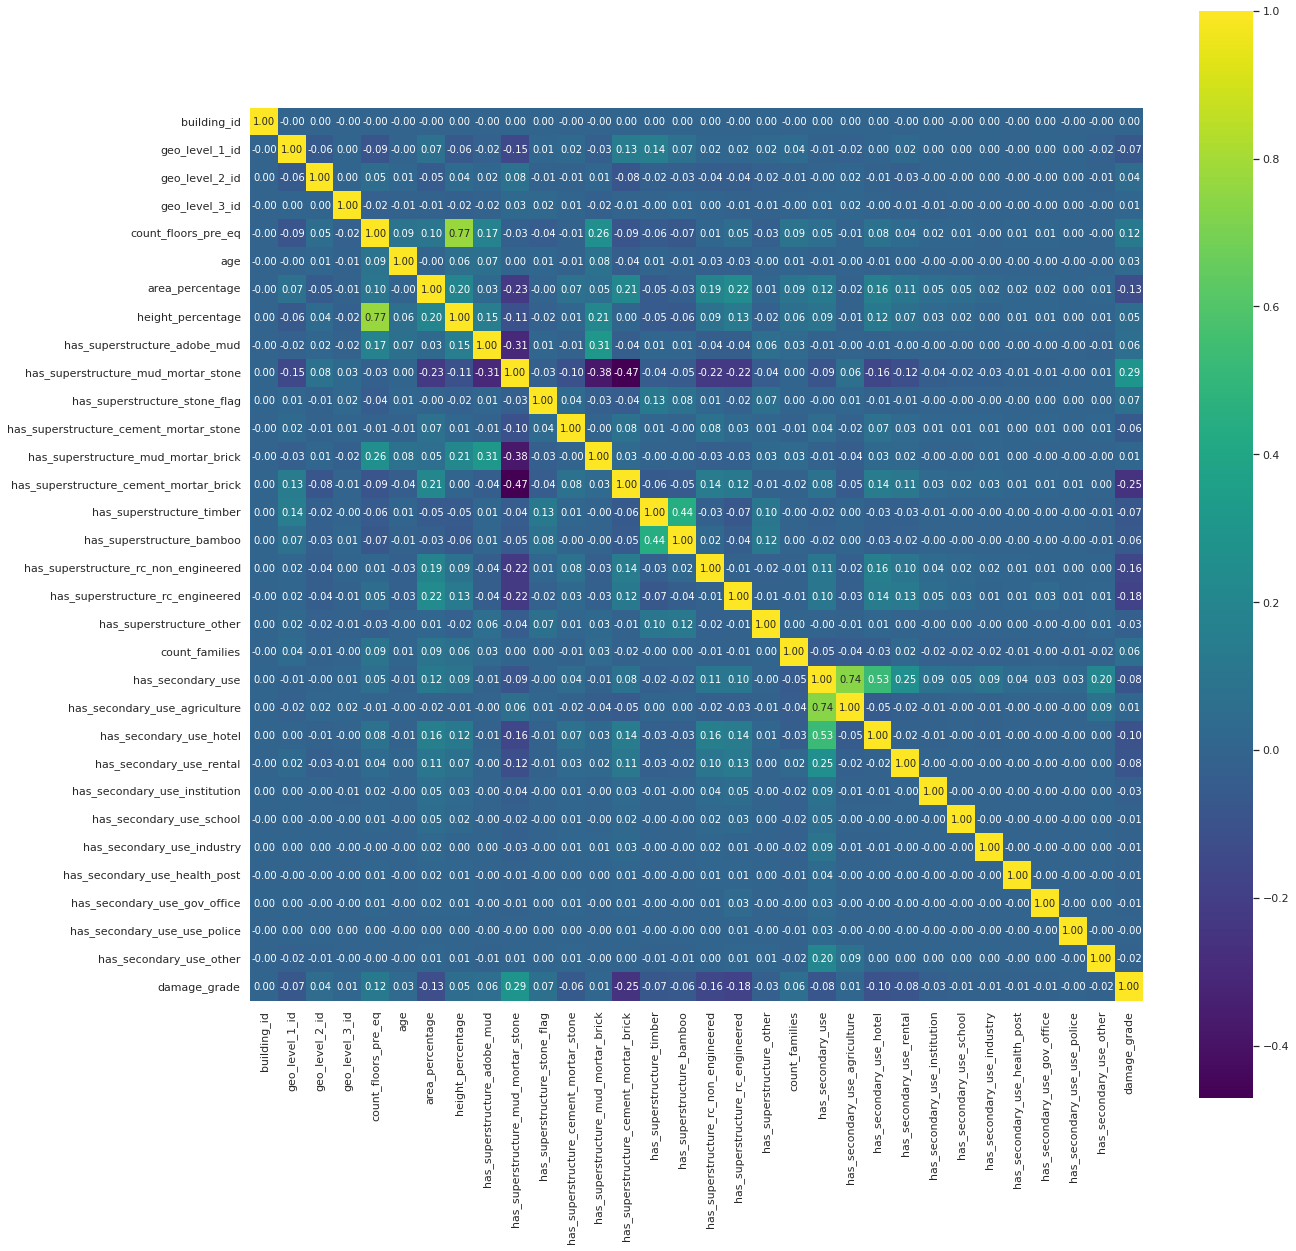

In [83]:
plt.figure(figsize=(20,20))

sns.heatmap(corr_matrix, annot=True, cmap='viridis', square=True, fmt='.2f', annot_kws={'size': 10})
plt.show()

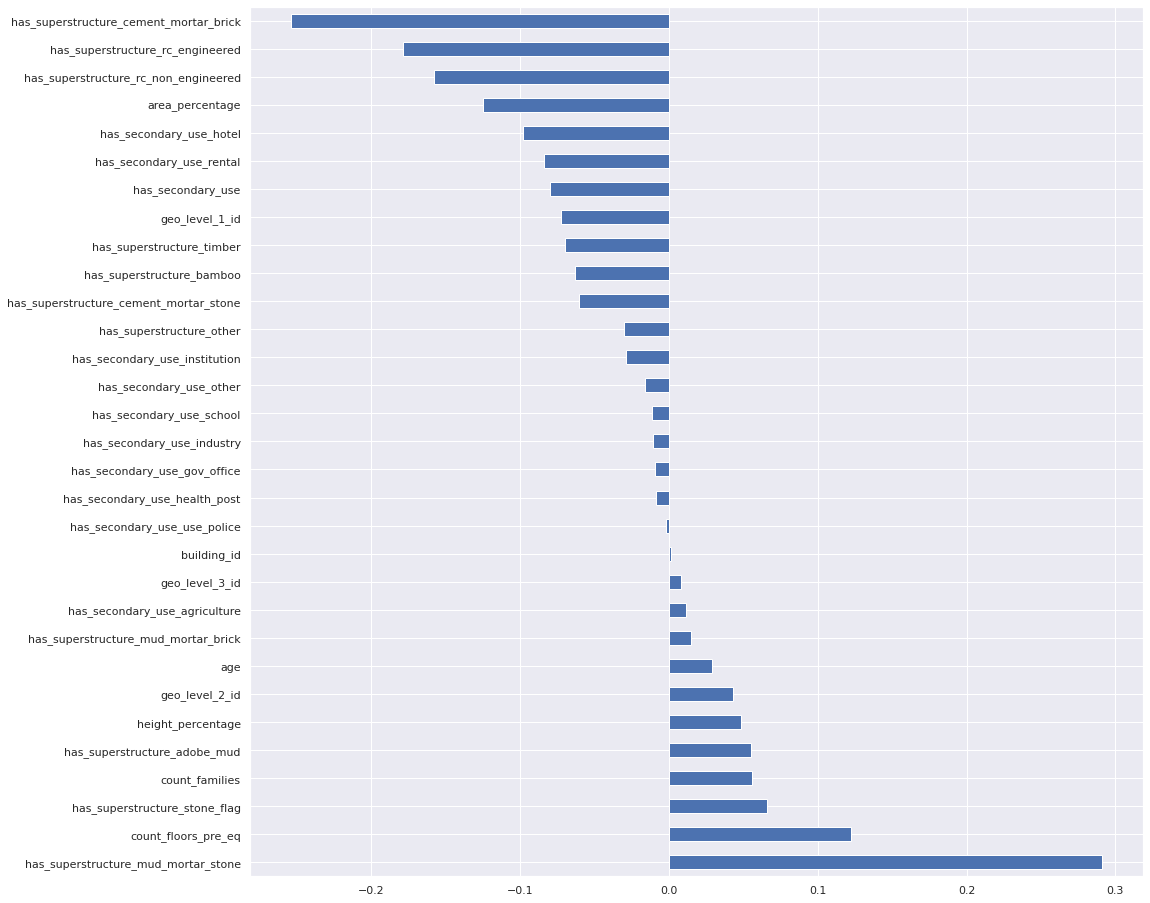

In [84]:
plt.figure(figsize=(16,16))

corr_matrix['damage_grade'].drop('damage_grade').sort_values(ascending=False).plot(kind='barh')
plt.show()

### EDA (Recommendation Material and Characteristic)

In [85]:
list_corr = corr_matrix['damage_grade'].drop('damage_grade')

#### Recommendation Material

Definisikan *features* yang termasuk ke dalam kategori material adalah 
*   ***has_superstructure_adobe_mud***
*   ***has_superstructure_mud_mortar_stone***
*   ***has_superstructure_stone_flag***
*   ***has_superstructure_cement_mortar_stone***
*   ***has_superstructure_mud_mortar_brick***
*   ***has_superstructure_cement_mortar_brick***
*   ***has_superstructure_timber***
*   ***has_superstructure_bamboo***
*   ***has_superstructure_rc_non_engineered***
*   ***has_superstructure_rc_engineered***
*   ***has_superstructure_other***


In [86]:
list_corr.loc[[
              'has_superstructure_adobe_mud', 
              'has_superstructure_mud_mortar_stone',
              'has_superstructure_stone_flag',
              'has_superstructure_cement_mortar_stone',
              'has_superstructure_mud_mortar_brick',
              'has_superstructure_cement_mortar_brick', 
              'has_superstructure_timber',
              'has_superstructure_bamboo', 
              'has_superstructure_rc_non_engineered',
              'has_superstructure_rc_engineered', 
              'has_superstructure_other'
              ]]

has_superstructure_adobe_mud              0.055314
has_superstructure_mud_mortar_stone       0.291325
has_superstructure_stone_flag             0.066039
has_superstructure_cement_mortar_stone   -0.060295
has_superstructure_mud_mortar_brick       0.014561
has_superstructure_cement_mortar_brick   -0.254131
has_superstructure_timber                -0.069852
has_superstructure_bamboo                -0.063051
has_superstructure_rc_non_engineered     -0.158145
has_superstructure_rc_engineered         -0.179014
has_superstructure_other                 -0.030224
Name: damage_grade, dtype: float64

Berdasarkan gambar dari pengaruh *features* material bangunan terhadap tingkat kerusakan bangunan, kita akan memilih 4 *features* material yang memiliki tingkat korelasi tertinggi dengan **damage_grade**. 4 *features* tersebut adalah **has_superstructure_mud_mortar_stone**, **has_superstructure_cement_mortar_brick**, **has_superstructure_rc_engineered**, dan **has_superstructure_rc_non_engineered**. Diperoleh beberapa *insight* berdasarkan data pada proses EDA sebelumnya yaitu.
*  Bangunan yang tidak mempunyai superstruktur *Reinforce Concrete Engineered* banyak mengalami tingkat kerusakan menengah dan tinggi jika dilihat berdarkan persebaranya terhadap jumlah lantai, tinggi bangunan, dan luas bangunan.
*  Jumlah bangunan yang menggunakan superstruktur *Reinforce Concrete Non Engineered* mengalami tingkat kerusakan mengengah lebih daripada jumlah bangunan yang menggunakan superstruktur *Reinforce Concrete Engineered* jika dilihat berdarkan persebaranya terhadap jumlah lantai, tinggi bangunan, dan luas bangunan.
*  Bangunan yang menggunakan superstruktur *Cement Mortar Brick* mengalami tingkat kerusakan yang lebih rendah dibandingkan yang tidak menggunakan.

Maka dari itu kita dapat memberikan rekomendasi karakteristik bangunan (rumah) dengan ciri-ciri sebagai berikut.
*  Menggunakan superstruktur *Reinforce Conrete Engineered*
*  Menggunakan superstruktur *Cement Mortar Brick*

#### Recommendation Characteristic

Definisikan *features* yang termasuk ke dalam kategori karakteristik adalah 

*   ***count_floors_pre_eq***
*   ***age***
*   ***area_percentage***
*   ***height_percentage***
*   ***foundation_type***
*   ***roof_type***
*   ***ground_floor_type***
*   ***other_floor_type*** 
*   ***position***

In [87]:
list_corr.loc[['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage']]

count_floors_pre_eq    0.122308
age                    0.029273
area_percentage       -0.125221
height_percentage      0.048130
Name: damage_grade, dtype: float64

Berdasarkan gambar dari pengaruh *features* karakteristik bangunan terhadap tingkat kerusakan bangunan, diperoleh bangunan yang mengalami tingkat kerusakan terbanyak adalah bangunan dengan kriteria sebagai berikut.
*  Bangunan dengan jumlah lantai sebanyak 2
*  Bangunan yang berusia 0-50 tahun
*  Bangunan dengan tinggi ternormalisasi 3-9 $m$
*  Bangunan dengan luas ternormalisasi 4-10 $m^2$ 

Maka dari itu kita dapat memberikan rekomendasi karakteristik bangunan (rumah) dengan ciri-ciri sebagai berikut.
*  Bangunan dengan jumlah lantai sebanyak 1 atau 3
*  Bangunan dengan tinggi ternormalisasi kurang dari 3 $m$ atau lebih dari 9 $m$
*  Bangunan dengan luas ternormalisasi kurang dari 4 $m^2$ atau lebih dari 10 $m^2$

## Feature Selection

In [88]:
df = features.copy()
df = df.set_index('building_id')
df_num = df.select_dtypes(include=['int64', 'float64'])
df_cat = df.select_dtypes(include=['object'])

### Feature Selection for Numeric Feature

Pada matrik korelasi sebelumnya terlihat bahwa terdapat dua buah feature yang memiliki tingkat korelasi yang tinggi (>0.7). Penggunakan matrik korelasi dapat dilakukan untuk mengecek multicollinearity. Multicollinearity dapat menimbulkan masalah seperti redudansi dimana dua feature tersebut dapat menyimpan informasi yang serupa/mirip. Dalam mengatasi multicollinearity, kita dapat membuang dua buah feature tersebut atau salah satu agar tidak ada feature yang mempunyai tingkat korelasi yang tinggi dengan feature lain. Akan dicek antara feature ***height_percentage*** dan ***has_secondary_use_agriculture*** yang mempunyai tingkat korelasi lebih tinggi terhadap target ***damage_grade***.

In [89]:
corr_matrix.loc['height_percentage', 'damage_grade']

0.048130023669951234

In [90]:
print('Korelasi feature height_percentange dengan damage_grade : {:.4f}'.format(corr_matrix.loc['height_percentage', 'damage_grade']))
print('Korelasi feature has_secondary_use_agriculture dengan damage_grade : {:.4f}'.format(corr_matrix.loc['has_secondary_use_agriculture', 'damage_grade']))

Korelasi feature height_percentange dengan damage_grade : 0.0481
Korelasi feature has_secondary_use_agriculture dengan damage_grade : 0.0113


Berdasarkan nilai korelasi di atas, terlihat bahwa feature ***height_percentage*** mempunyai tingkat korelasi yang lebih tinggi, maka kita akan membuang feature ***has_secondary_use_agriculture***.

In [91]:
df_num = df_num.drop('has_secondary_use_agriculture', axis=1)
df_num.shape

(260601, 30)

### Feature Selection for Categorical Feature

Proses pemilihan feature yang bertipe kategorikal akan menggunakan *SelectKBest*. Menggunakan hal ini, digunakan metrics *chi squared* yang mana jika *chi squared* semakin tinggi, maka semakin signifikan pengaruh dari feature tersebut.

In [92]:
df_cat = pd.get_dummies(df_cat)
df_cat.head()

,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
28830,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
94947,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
590882,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
201944,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [93]:
df_cat.shape

(260601, 38)

In [94]:
category_rank_feature = SelectKBest(score_func=chi2, k=38)
rank_feature = category_rank_feature.fit(df_cat, df_num['damage_grade'])
rank_feature.scores_

array([3.14202700e+02, 6.77046429e+01, 6.77640172e+01, 4.15860728e+02,
       2.79293047e+04, 6.39195232e+03, 5.49424844e+03, 8.31579458e+03,
       1.04584801e+03, 1.15697625e+03, 2.80485950e+04, 3.68489235e+03,
       9.75543604e+01, 3.24654211e+04, 6.05516649e+01, 1.22429528e+02,
       7.42291993e+03, 5.10846128e+03, 1.85494082e+04, 4.06602490e+02,
       2.59354872e+02, 1.48779877e+02, 4.93714399e+01, 6.22421247e+02,
       1.09200110e+02, 1.50572497e+02, 3.04753264e+01, 3.34305427e+00,
       1.36435198e+01, 1.65187836e+00, 5.72019260e+01, 3.23110604e+02,
       3.31565900e+01, 1.01176162e+03, 2.26362245e+03, 5.34417037e+01,
       3.96056239e+01, 2.29493063e+02])

In [95]:
cat_score = pd.DataFrame(rank_feature.scores_, columns=['Score'])
cat_col = pd.DataFrame(df_cat.columns, columns=['Feature'])
univariate_cat_rank = pd.concat([cat_col, cat_score], axis=1)
univariate_cat_rank.set_index('Feature', inplace=True)
sorted_univariate_cat_rank = univariate_cat_rank.sort_values('Score', ascending=False)

Ambil feature dengan nilai chi2 lebih dari 100.

In [96]:
chi2_greater100 = sorted_univariate_cat_rank[sorted_univariate_cat_rank['Score']>100]

### Merge Numeric and Categorical Feature

In [97]:
df_new = pd.concat([df_num, df_cat], axis=1)

In [98]:
df_new.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
28830,8,900,2812,2,10,8,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
94947,21,363,8973,2,10,5,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
590882,22,418,10694,2,10,6,5,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
201944,11,131,1488,3,30,8,9,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


## Building Model

### Split Data into Train Data and Validation Data

Pisahkan data yang akan digunakan sebagai label atau target variabel dengan feature lainnya. Dalam kasus ini kita membuat variabel y yang menyimpan target variabel dan X yang menyimpan feature lainnya.

In [99]:
data = df_new.copy()
y = data['damage_grade']
X = data[list(df_num.columns)+list(chi2_greater100.index)]
X.drop('damage_grade', axis=1, inplace=True)

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((208480, 54), (52121, 54), (208480,), (52121,))

In [101]:
X_train.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,ground_floor_type_v,roof_type_x,foundation_type_i,other_floor_type_s,foundation_type_w,other_floor_type_j,foundation_type_r,foundation_type_u,other_floor_type_q,ground_floor_type_f,legal_ownership_status_a,roof_type_q,roof_type_n,plan_configuration_u,position_t,foundation_type_h,other_floor_type_x,plan_configuration_q,land_surface_condition_n,position_j,legal_ownership_status_w,plan_configuration_c,position_o,ground_floor_type_z,plan_configuration_a
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
882292,20,281,7097,2,15,6,7,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
193569,26,886,12157,2,10,6,6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
898082,26,36,1125,1,0,5,3,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
136982,13,1372,4555,2,10,6,5,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
742018,8,206,6064,3,35,6,5,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0


In [102]:
X_test.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,ground_floor_type_v,roof_type_x,foundation_type_i,other_floor_type_s,foundation_type_w,other_floor_type_j,foundation_type_r,foundation_type_u,other_floor_type_q,ground_floor_type_f,legal_ownership_status_a,roof_type_q,roof_type_n,plan_configuration_u,position_t,foundation_type_h,other_floor_type_x,plan_configuration_q,land_surface_condition_n,position_j,legal_ownership_status_w,plan_configuration_c,position_o,ground_floor_type_z,plan_configuration_a
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
315409,6,449,484,2,0,9,8,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
838451,27,548,2513,2,0,5,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
808750,24,780,9035,3,25,4,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
322968,10,661,6346,3,30,6,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
212418,10,1207,276,2,15,5,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [103]:
y_train.head().to_frame()

,damage_grade
building_id,
882292,1
193569,1
898082,1
136982,2
742018,3


In [104]:
y_test.head().to_frame()

,damage_grade
building_id,
315409,2
838451,3
808750,2
322968,2
212418,3


### Scaling Data

Dalam tahapan *preprocessing* data, kita akan menerapkan **StandardScaler** untuk melakukan normalisasi pada data pada *scaled_col*

In [105]:
scaler = StandardScaler()

scaled_col = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 
              'count_floors_pre_eq', 'age', 'area_percentage', 
              'height_percentage']

X_train[scaled_col] = scaler.fit_transform(X_train[scaled_col])
X_test[scaled_col] = scaler.transform(X_test[scaled_col])

In [106]:
X_train.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,ground_floor_type_v,roof_type_x,foundation_type_i,other_floor_type_s,foundation_type_w,other_floor_type_j,foundation_type_r,foundation_type_u,other_floor_type_q,ground_floor_type_f,legal_ownership_status_a,roof_type_q,roof_type_n,plan_configuration_u,position_t,foundation_type_h,other_floor_type_x,plan_configuration_q,land_surface_condition_n,position_j,legal_ownership_status_w,plan_configuration_c,position_o,ground_floor_type_z,plan_configuration_a
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
882292,0.758641,-1.019753,0.228478,-0.178354,-0.156363,-0.461464,0.817733,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
193569,1.505643,0.446238,1.615688,-0.178354,-0.224906,-0.461464,0.295711,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
898082,1.505643,-1.613419,-1.408759,-1.556477,-0.361991,-0.690498,-1.270355,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
136982,-0.112861,1.623877,-0.468417,-0.178354,-0.224906,-0.461464,-0.226311,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
742018,-0.735362,-1.201487,-0.054721,1.199770,0.117809,-0.461464,-0.226311,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0


In [107]:
X_test.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,ground_floor_type_v,roof_type_x,foundation_type_i,other_floor_type_s,foundation_type_w,other_floor_type_j,foundation_type_r,foundation_type_u,other_floor_type_q,ground_floor_type_f,legal_ownership_status_a,roof_type_q,roof_type_n,plan_configuration_u,position_t,foundation_type_h,other_floor_type_x,plan_configuration_q,land_surface_condition_n,position_j,legal_ownership_status_w,plan_configuration_c,position_o,ground_floor_type_z,plan_configuration_a
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
315409,-0.984363,-0.612668,-1.584491,-0.178354,-0.361991,0.225640,1.339754,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
838451,1.630143,-0.372778,-1.028236,-0.178354,-0.361991,-0.690498,-0.226311,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
808750,1.256643,0.189387,0.759785,1.199770,-0.019277,-0.919532,0.817733,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
322968,-0.486362,-0.098965,0.022590,1.199770,0.049266,-0.461464,0.817733,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
212418,-0.486362,1.224061,-1.641514,-0.178354,-0.156363,-0.690498,-0.226311,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


### Using Cross Validation

Dalam membandingkan *performance* dari beberapa algoritma *machine learning* yang akan diuji, kita akan menggunakan metric **F1 Score Micro**. Adapun asalan digunakan **F1 Score** sebagai metric adalah kita ingin membuat suatu model machine learning yang dapat memaksimalkan nilai dari *Precision* dan *Recall* yang baik. Metric *Precision* dan *Recall* dianggap penting karena nilai FN(*False Negative*) dan FP(*False Positive*) adalah faktor penting. Selain itu, metric **F1 Score** dianggap lebih baik saat bekerja dengan kelas yang tidak seimbang. Untuk **Micro** sendiri dipilih dikarenakan kita ingin menghitung terlebih dahulu penjumlahan dari semua TP(*True Positive*), FP(*False Positive*), dan FN(*False Negative*) dari semua kelas pada target variabel.

Definisikan fungsi untuk membuat *confusion matrix*

In [108]:
def make_confusion_matrix(pred, title):
    cam = confusion_matrix(y_test, pred)
    sns.heatmap(cam, annot=True, cmap='viridis', 
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'],
                fmt="d")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix Using {} Algorithm'.format(title))
    plt.show()

#### Logistic Regression

In [109]:
model_cv_1 = LogisticRegression(random_state=0)
kfold = KFold(n_splits=10)
scores_1 = cross_val_score(model_cv_1, X_train, y_train, scoring="f1_micro", cv=kfold)
result_1 = scores_1.mean()
print('Average F1 Score (Micro) for Logistic Algorithm is : {}'.format(result_1))

Average F1 Score (Micro) for Logistic Algorithm is : 0.5910830775134305


#### Decision Tree

In [110]:
model_cv_2 = DecisionTreeClassifier(random_state=0)
kfold = KFold(n_splits=10)
scores_2 = cross_val_score(model_cv_2, X_train, y_train, scoring="f1_micro", cv=kfold)
result_2 = scores_2.mean()
print('Average F1 Score (Micro) for Decision Tree is : {}'.format(result_2))

Average F1 Score (Micro) for Decision Tree is : 0.6576026477359939


#### K-Nearest Neighbors

In [111]:
model_cv_3 = KNeighborsClassifier()
kfold = KFold(n_splits=10)
scores_3 = cross_val_score(model_cv_3, X_train, y_train, scoring="f1_micro", cv=kfold)
result_3 = scores_3.mean()
print('Average F1 Score (Micro) for K-Nearest Neighbors is : {}'.format(result_3))

Average F1 Score (Micro) for K-Nearest Neighbors is : 0.6561300844205679


#### Linear Discriminant Analysis

In [112]:
model_cv_4 = LinearDiscriminantAnalysis()
kfold = KFold(n_splits=10)
scores_4 = cross_val_score(model_cv_4, X_train, y_train, scoring="f1_micro", cv=kfold)
result_4 = scores_4.mean()
print('Average F1 Score (Micro) for Linear Discriminant Analysis is : {}'.format(result_4))

Average F1 Score (Micro) for Linear Discriminant Analysis is : 0.5867661166538757


#### Naive Bayes

In [117]:
model_cv_5 = GaussianNB()
kfold = KFold(n_splits=10)
scores_5 = cross_val_score(model_cv_5, X_train, y_train, scoring="f1_micro", cv=kfold)
result_5 = scores_5.mean()
print('Average F1 Score (Micro) for Naive Bayes is : {}'.format(result_5))

Average F1 Score (Micro) for Naive Bayes is : 0.430962202609363


#### Extreme Gradient Boosting

In [132]:
model_cv_6 = XGBClassifier(verbosity=0)
kfold = KFold(n_splits=10)
scores_6 = cross_val_score(model_cv_6, X_train, y_train, scoring="f1_micro", cv=kfold)
result_6 = scores_6.mean()
print('Average F1 Score (Micro) for Extreme Gradient Boosting is : {}'.format(result_6))

Average F1 Score (Micro) for Extreme Gradient Boosting is : 0.6741797774366847


#### Random Forest

In [122]:
model_cv_7 = RandomForestClassifier(random_state=0)
kfold = KFold(n_splits=10)
scores_7 = cross_val_score(model_cv_7, X_train, y_train, scoring="f1_micro", cv=kfold)
result_7 = scores_7.mean()
print('Average F1 Score (Micro) for Random Forest is : {}'.format(result_7))

Average F1 Score (Micro) for Random Forest is : 0.7145577513430544


### Fit and Predict Several Algorithm

#### Logistic Regression

              precision    recall  f1-score   support

           1       0.57      0.30      0.39      4979
           2       0.60      0.88      0.71     29703
           3       0.56      0.20      0.29     17439

    accuracy                           0.59     52121
   macro avg       0.58      0.46      0.47     52121
weighted avg       0.58      0.59      0.54     52121



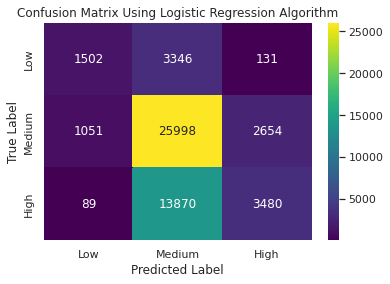

Train F1 Score (Micro) for Logistic Regression Algorithm is : 0.591514773599386
Test F1 Score (Micro) for Logistic Regression Algorithm is : 0.5943861399435928


In [123]:
model_1 = LogisticRegression()
model_1.fit(X_train, y_train)
pred_1 = model_1.predict(X_test)
train_pred_1 = model_1.predict(X_train)

print(classification_report(y_test, pred_1))
make_confusion_matrix(pred_1, 'Logistic Regression')
train_score_1 = f1_score(y_train, train_pred_1, average='micro')
score_1 = f1_score(y_test, pred_1, average='micro')
print('Train F1 Score (Micro) for Logistic Regression Algorithm is : {}'.format(train_score_1))
print('Test F1 Score (Micro) for Logistic Regression Algorithm is : {}'.format(score_1))

with open('model_1', 'wb') as files:
    pickle.dump(model_1, files)

#### Decision Tree

In [124]:
model_2 = DecisionTreeClassifier()
model_2.fit(X_train, y_train)
pred_2 = model_2.predict(X_test)
train_pred_2 = model_2.predict(X_train)

print(classification_report(y_test, pred_2))
#make_confusion_matrix(pred_2, 'Decision Tree')
train_score_2 = f1_score(y_train, train_pred_2, average='micro')
score_2 = f1_score(y_test, pred_2, average='micro')
print('Train F1 Score (Micro) for Decision Tree Algorithm is : {}'.format(train_score_2))
print('Test F1 Score (Micro) for Decision Tree Algorithm is : {}'.format(score_2))

with open('model_2', 'wb') as files:
    pickle.dump(model_2, files)

              precision    recall  f1-score   support

           1       0.48      0.51      0.50      4979
           2       0.71      0.71      0.71     29703
           3       0.62      0.62      0.62     17439

    accuracy                           0.66     52121
   macro avg       0.61      0.61      0.61     52121
weighted avg       0.66      0.66      0.66     52121

Train F1 Score (Micro) for Decision Tree Algorithm is : 0.9864207597851112
Test F1 Score (Micro) for Decision Tree Algorithm is : 0.6600986166804167


#### K-Nearest Neighbors

In [125]:
model_3 = KNeighborsClassifier()
model_3.fit(X_train, y_train)
pred_3 = model_3.predict(X_test)
train_pred_3 = model_3.predict(X_train)

print(classification_report(y_test, pred_3))
#make_confusion_matrix(pred_3, 'K-Nearest Neighbors')
train_score_3 = f1_score(y_train, train_pred_3, average='micro')
score_3 = f1_score(y_test, pred_3, average='micro')
print('Train F1 Score (Micro) for K-Nearest Neighbors Algorithm is : {}'.format(train_score_3))
print('Test F1 Score (Micro) for K-Nearest Neighbors Algorithm is : {}'.format(score_3))

with open('model_3', 'wb') as files:
    pickle.dump(model_3, files)

              precision    recall  f1-score   support

           1       0.52      0.46      0.49      4979
           2       0.69      0.75      0.72     29703
           3       0.63      0.56      0.59     17439

    accuracy                           0.66     52121
   macro avg       0.61      0.59      0.60     52121
weighted avg       0.65      0.66      0.66     52121

Train F1 Score (Micro) for K-Nearest Neighbors Algorithm is : 0.7664907904834997
Test F1 Score (Micro) for K-Nearest Neighbors Algorithm is : 0.6589666353293299


#### Linear Discriminant Analysis

In [126]:
model_4 = LinearDiscriminantAnalysis()
model_4.fit(X_train, y_train)
pred_4 = model_4.predict(X_test)
train_pred_4 = model_4.predict(X_train)

print(classification_report(y_test, pred_4))
#make_confusion_matrix(pred_4, 'Linear Discriminant Analysis')
train_score_4 = f1_score(y_train, train_pred_4, average='micro')
score_4 = f1_score(y_test, pred_4, average='micro')
print('Train F1 Score (Micro) for Linear Discriminant Analysis Algorithm is : {}'.format(train_score_4))
print('Test F1 Score (Micro) for Linear Discriminant Analysis Algorithm is : {}'.format(score_4))

with open('model_4', 'wb') as files:
    pickle.dump(model_4, files)

              precision    recall  f1-score   support

           1       0.49      0.50      0.50      4979
           2       0.60      0.85      0.70     29703
           3       0.57      0.18      0.27     17439

    accuracy                           0.59     52121
   macro avg       0.55      0.51      0.49     52121
weighted avg       0.58      0.59      0.54     52121

Train F1 Score (Micro) for Linear Discriminant Analysis Algorithm is : 0.587212202609363
Test F1 Score (Micro) for Linear Discriminant Analysis Algorithm is : 0.5883233245716698


#### Naive Bayes

In [127]:
model_5 = GaussianNB()
model_5.fit(X_train, y_train)
pred_5 = model_5.predict(X_test)
train_pred_5 = model_5.predict(X_train)

print(classification_report(y_test, pred_5))
#make_confusion_matrix(pred_5, 'Naive Bayes')
train_score_5 = f1_score(y_train, train_pred_5, average='micro')
score_5 = f1_score(y_test, pred_5, average='micro')
print('Train F1 Score (Micro) for Naive Bayes Algorithm is : {}'.format(train_score_5))
print('Test F1 Score (Micro) for Naive Bayes Algorithm is : {}'.format(score_5))

with open('model_5', 'wb') as files:
    pickle.dump(model_5, files)

              precision    recall  f1-score   support

           1       0.39      0.52      0.45      4979
           2       0.66      0.15      0.25     29703
           3       0.40      0.88      0.55     17439

    accuracy                           0.43     52121
   macro avg       0.49      0.52      0.42     52121
weighted avg       0.55      0.43      0.37     52121

Train F1 Score (Micro) for Naive Bayes Algorithm is : 0.43118284727551803
Test F1 Score (Micro) for Naive Bayes Algorithm is : 0.4337982770860114


#### Extreme Gradient Boosting

In [128]:
model_6 = XGBClassifier(verbosity=0, tree_method='gpu_hist')
model_6.fit(X_train, y_train)
pred_6 = model_6.predict(X_test)
train_pred_6 = model_6.predict(X_train)

print(classification_report(y_test, pred_6))
#make_confusion_matrix(pred_6, 'Extreme Gradient Boosting')
train_score_6 = f1_score(y_train, train_pred_6, average='micro')
score_6 = f1_score(y_test, pred_6, average='micro')
print('Train F1 Score (Micro) for Extreme Gradient Boosting Algorithm is : {}'.format(train_score_6))
print('Test F1 Score (Micro) for Extreme Gradient Boosting Algorithm is : {}'.format(score_6))

with open('model_6', 'wb') as files:
    pickle.dump(model_6, files)

              precision    recall  f1-score   support

           1       0.61      0.36      0.45      4979
           2       0.66      0.88      0.75     29703
           3       0.73      0.42      0.53     17439

    accuracy                           0.67     52121
   macro avg       0.67      0.55      0.58     52121
weighted avg       0.68      0.67      0.65     52121

Train F1 Score (Micro) for Extreme Gradient Boosting Algorithm is : 0.6749760168841136
Test F1 Score (Micro) for Extreme Gradient Boosting Algorithm is : 0.6737207651426488


#### Random Forest

In [129]:
model_7 = RandomForestClassifier(random_state=0)
model_7.fit(X_train, y_train)
pred_7 = model_7.predict(X_test)
train_pred_7 = model_7.predict(X_train)

print(classification_report(y_test, pred_7))
#make_confusion_matrix(pred_7, 'Random Forest')
train_score_7 = f1_score(y_train, train_pred_7, average='micro')
score_7 = f1_score(y_test, pred_7, average='micro')
print('Train F1 Score (Micro) for Random Forest Algorithm is : {}'.format(train_score_7))
print('Test F1 Score (Micro) for Random Forest Algorithm is : {}'.format(score_7))

with open('model_7', 'wb') as files:
    pickle.dump(model_7, files)

              precision    recall  f1-score   support

           1       0.64      0.47      0.54      4979
           2       0.72      0.83      0.77     29703
           3       0.72      0.59      0.65     17439

    accuracy                           0.71     52121
   macro avg       0.69      0.63      0.65     52121
weighted avg       0.71      0.71      0.71     52121

Train F1 Score (Micro) for Random Forest Algorithm is : 0.9864111665387567
Test F1 Score (Micro) for Random Forest Algorithm is : 0.7142418602866407


### Comparing Algorithm

In [130]:
names = ['Logistic Regression', 'Decision Tree', 'K-Nearest Neighbors', 'Linear Discriminant Analysis',
         'Naive Bayes', 'Extreme Gradient Boosting', 'Random Forest']
cv_score_f1 = [result_1, result_2, result_3, result_4, result_5, result_6, result_7]
train_score_f1 = [train_score_1, train_score_2, train_score_3, train_score_4, train_score_5, train_score_6, train_score_7]
score_f1 = [score_1, score_2, score_3, score_4, score_5, score_6, score_7]

In [131]:
compare = pd.DataFrame()
compare['Algorithm'] = names
compare['CV F1 Score'] = cv_score_f1
compare['F1 Score (Train)'] = train_score_f1
compare['F1 Score (Test)'] = score_f1
compare

,Algorithm,CV F1 Score,F1 Score (Train),F1 Score (Test)
0,Logistic Regression,0.591083,0.591515,0.594386
1,Decision Tree,0.657603,0.986421,0.660099
2,K-Nearest Neighbors,0.656130,0.766491,0.658967
3,Linear Discriminant Analysis,0.586766,0.587212,0.588323
4,Naive Bayes,0.430962,0.431183,0.433798
5,Extreme Gradient Boosting,0.674180,0.674976,0.673721
6,Random Forest,0.714558,0.986411,0.714242


Menggunakan 7 buah algoritma *Machine Learning* dengan random_state = 0, kita melihat bahwa *Random Forest Algorithm* dan *Extreme Gradient Boosting* adalah 2 algoritma yang memberikan nilai F1 Score tertinggi saat diuji di data *test* (*Valudation Data*).

### Hyperparameter Tuning

Pada bagian sebelumnya, diperoleh 2 buah algoritma yang menghasilkan nilai F1 Score tertinggi yaitu Extreme *Gradient Boosting* dan *Random Forest*. Oleh karena itu, kita akan melakukan proses *Hyperparameter Tuning* pada dua algoritma tersebut. Proses *hyperparameter tuning* dapat melakukan GridSearchCV atau RandomizedCV. Pada permasalahan kali ini, kita akan menggunakan RandomizedCV.

#### Extreme Gradient Boosting Parameter Tuning

In [135]:
xgb_params = {'n_estimators':range(50, 201, 50),
              'max_depth': range(3, 15)}
xgb_model = XGBClassifier(tree_method="gpu_hist", verbosity=0)
kfold = KFold(n_splits=4)
rscv_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=xgb_params, n_iter=5,
                              scoring='f1_micro', cv=kfold, random_state=0, n_jobs=-1)

rscv_xgb.fit(X,y)
print("Optimal hyperparameter combination for XGBClassifier:", rscv_xgb.best_params_)
print()
print("Mean cross-validated training accuracy score:", rscv_xgb.best_score_)

with open('rscv_xgb', 'wb') as files:
    pickle.dump(rscv_xgb, files)

Optimal hyperparameter combination for XGBClassifier: {'n_estimators': 150, 'max_depth': 10}

Mean cross-validated training accuracy score: 0.7340455365552411


#### Random Forest Parameter Tuning

In [136]:
params = {'n_estimators': range(50, 251, 50),
          'max_depth': range(15, 30),
          'max_features': ['sqrt', 'log2', None]}

rf_model = RandomForestClassifier(random_state=0)
kfold = KFold(n_splits=4)
rscv_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=params, n_iter=5, 
                             scoring='f1_micro', cv=kfold, random_state=0, n_jobs=-1)

rscv_rf.fit(X,y)
print("Optimal hyperparameter combination for RandomForestClassifier:", rscv_rf.best_params_)
print()
print("Mean cross-validated training accuracy score:", rscv_rf.best_score_)

with open('rscv_rf', 'wb') as files:
    pickle.dump(rscv_rf, files)

Optimal hyperparameter combination for RandomForestClassifier: {'n_estimators': 100, 'max_features': None, 'max_depth': 21}

Mean cross-validated training accuracy score: 0.7339687866382028


### Build Model With Parameter Tuning

#### Extreme Gradient Boosting

In [137]:
tuning_xgb_model = XGBClassifier(n_estimators=150, max_depth=10, verbosity=0, tree_method="gpu_hist")
tuning_xgb_model.fit(X_train,y_train)
pred_xgb = tuning_xgb_model.predict(X_test)
train_pred_xgb = tuning_xgb_model.predict(X_train)
print('F1 Score (Micro) on Training Data :', f1_score(y_train, train_pred_xgb, average='micro'))
print('F1 Score (Micro) on Testing Data :', f1_score(y_test, pred_xgb, average='micro'))

with open('tuning_xgb_model', 'wb') as files:
    pickle.dump(tuning_xgb_model, files)

F1 Score (Micro) on Training Data : 0.7942680353031466
F1 Score (Micro) on Testing Data : 0.7356343892097237


#### Random Forest

In [138]:
tuning_rf_model = RandomForestClassifier(n_estimators=100, max_features=None, max_depth=21, random_state=0)
tuning_rf_model.fit(X_train,y_train)
pred_rf = tuning_rf_model.predict(X_test)
train_pred_rf = tuning_rf_model.predict(X_train)
print('F1 Score (Micro) on Training Data :', f1_score(y_train, train_pred_rf, average='micro'))
print('F1 Score (Micro) on Testing Data :', f1_score(y_test, pred_rf, average='micro'))

with open('tuning_rf_model', 'wb') as files:
    pickle.dump(tuning_rf_model, files)

F1 Score (Micro) on Training Data : 0.8994675748273215
F1 Score (Micro) on Testing Data : 0.7350204332226934


### Feature Importance

#### Extreme Gradient Boosting

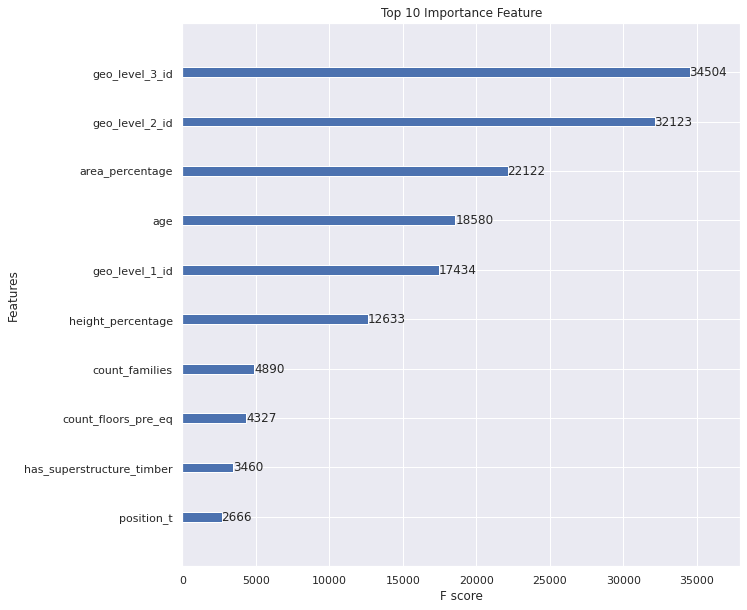

In [139]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_importance(tuning_xgb_model, max_num_features=10, ax=ax)
plt.title('Top 10 Importance Feature')
plt.show()

Menggunakan *Extreme Gradient Boosting*, diperoleh 10 *feature* terpenting dalam model yaitu `geo_level_3_id`, `geo_level_2_id`, `area_percentage`, `age`, `geo_level_1_id`, `height_percentage`, `count_families`, `count_floors_pre_eq`, `has_superstructure_timber`, `position_t`. 

#### Random Forest

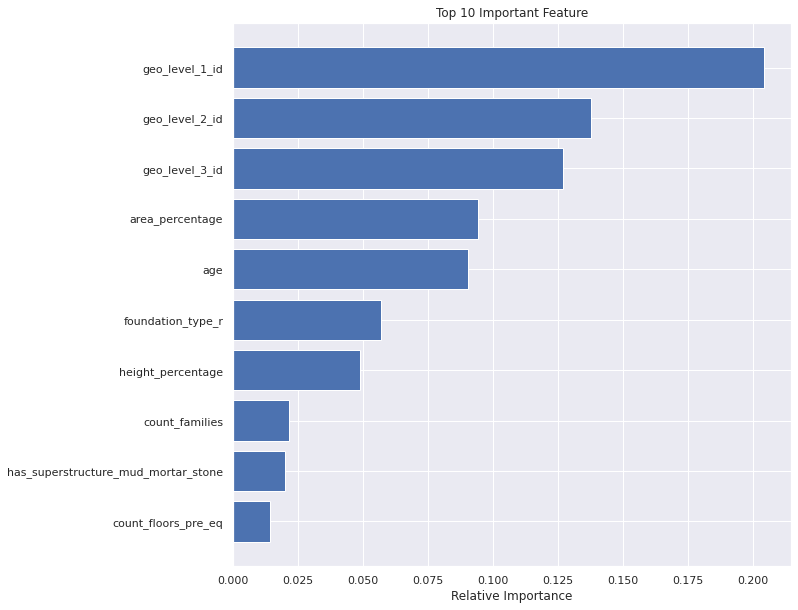

In [140]:
features = X.columns
importances = tuning_rf_model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10,10))
plt.title('Feature Importances')
plt.barh(range(len(indices[-10:])), importances[indices][-10:], color='b', align='center')
plt.yticks(range(len(indices[-10:])), features[indices][-10:])
plt.xlabel('Relative Importance')
plt.title('Top 10 Important Feature')
plt.show()

Menggunakan *Random Forest*, diperoleh 10 *feature* terpenting dalam model yaitu `geo_level_1_id`, `geo_level_2_id`, `geo_level_3_id``area_percentage`, `age`, `foundation_type_r`, `height_percentage`, `count_families`, `has_superstructure_mud_mortar_stone`, `count_floors_pre_eq`.

## Final Model

Setelah dilakukan proses parameter tuning untuk *Extreme Gradient Boosting* dan *Random Forest*, diperoleh nilai F1 score untuk kedua model pada *training data* dan *validation data*. Terlihat untuk model pada *Extreme Gradient Boosting* lebih stabil karena nilai F1 score pada *training data* dan *validation data* berada di rentang 79.4% dan 73.5%. Sementara pada model *Random Forest*, nilai F1 score pada *training data* adalah 89.9% dan 73.5% pada *validation data*. Sehingga pada model akhir, kita akan menggunakan *Extreme Gradient Boosting* untuk memprediksi *test data*.

In [141]:
def final_confusion_matrix(pred, title):
    cam = confusion_matrix(y, pred)
    sns.heatmap(cam, annot=True, cmap='viridis', 
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'],
                fmt="d")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix Using {} Algorithm'.format(title))
    plt.show()

In [142]:
scaler_final = StandardScaler()
scaled_col = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 
              'count_floors_pre_eq', 'age', 'area_percentage', 
              'height_percentage']
X[scaled_col] = scaler_final.fit_transform(X[scaled_col])

F1 Score (Micro) on Training Data : 0.7867276027336809
Classification report: 
               precision    recall  f1-score   support

           1       0.83      0.60      0.70     25124
           2       0.77      0.89      0.83    148259
           3       0.81      0.66      0.73     87218

    accuracy                           0.79    260601
   macro avg       0.80      0.72      0.75    260601
weighted avg       0.79      0.79      0.78    260601



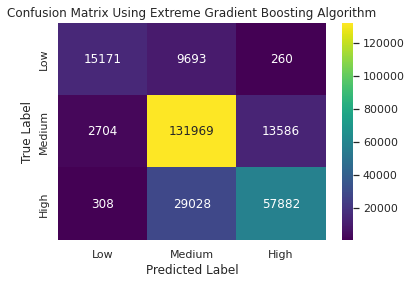

In [143]:
final_model = XGBClassifier(n_estimators=150, max_depth=10, verbosity=0, tree_method="gpu_hist")
final_model.fit(X, y)
pred_final_model = final_model.predict(X)
print('F1 Score (Micro) on Training Data :', f1_score(y, pred_final_model, average='micro'))
print('Classification report: \n',classification_report(y, pred_final_model))
final_confusion_matrix(pred_final_model, 'Extreme Gradient Boosting')

with open('final_model', 'wb') as files:
    pickle.dump(final_model, files)

## Predict on Unseen Data

Sekarang, akan diprediksi tingkat kerusakan pada bangunan yang ada pada data uji.

In [144]:
test_data = test_value.copy()
test_data = test_data.set_index('building_id')
test_data.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0
890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0
421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [145]:
test_data_num = test_data.select_dtypes(include=['int64', 'float64'])
test_data_cat = test_data.select_dtypes(include=['object'])

In [146]:
test_data_num = test_data_num.drop('has_secondary_use_agriculture', axis=1)

In [147]:
test_data_cat = pd.get_dummies(test_data_cat)

In [148]:
new_test_data = pd.concat([test_data_num, test_data_cat], axis=1)

In [149]:
scaler = StandardScaler()
scaled_test = new_test_data.copy()
data_train = df_new.copy()
scaled_col = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 
              'count_floors_pre_eq', 'age', 'area_percentage', 
              'height_percentage']

scaled_train = data_train[scaled_col]
scaler.fit(scaled_train)
feature_scaled_test = scaled_test[scaled_col]
feature_scaled_test = scaler.transform(feature_scaled_test)
scaled_test[scaled_col] = feature_scaled_test
data_test = scaled_test.copy()

In [150]:
data_test.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
300051,0.385835,-0.254597,1.384702,1.195989,-0.088832,-0.231785,0.294845,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
99355,-0.983414,-1.357066,1.571189,-0.178274,-0.020866,1.134266,-0.226419,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
890251,1.008221,-1.652673,1.038329,-0.178274,-0.292732,-0.914810,-0.226419,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
745817,1.506130,-1.604213,-1.542599,-1.552536,-0.360698,2.500317,-1.268946,0,0,0,0,0,1,0,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
421793,0.385835,-0.998461,0.469543,1.195989,-0.156799,-0.004110,0.816109,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [151]:
testing = data_test[list(df_num.drop('damage_grade', axis=1).columns)+list(chi2_greater100.index)]

In [152]:
pred_testing_data = final_model.predict(testing)

In [153]:
final = pd.DataFrame()
final['building_id'] = testing.index
final['damage_grade'] = pred_testing_data

In [154]:
final

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,2
3,745817,1
4,421793,3
...,...,...
86863,310028,2
86864,663567,2
86865,1049160,2
86866,442785,2


Akan disimpan hasil prediksi berupa tingkat kerusakan bangunan ke dalam file csv.

In [155]:
final.to_csv('Damage Grade Prediction.csv', index=False)

# Conclusion

Berdasarkan proses yang telah dilakukan, dapat diperoleh beberapa kesimpulan yang dapat menajwab permasalahan sebelumnya. Kesimpulan ini diharapkan dapat menjawab permasalahan yang telah didefinisikan sebelumnya.

1. Mendapatkan gambaran bagaimana kerusakan yang ada pada bangunan yang ada di Nepal <br>
Jawab :  <br>
Setelah melakukan proses *Exploratory Data Analysis*, diperoleh rata-rata tingkat kerusakan yang ada sebesar **2,238272** yang menyatakan bangunan mengalami tingkat kerusakan menengah. Adapun lengkapnya adalah sebanyak **148259** bangunan mengalami tingkat kerusakan menengah, **87218** bangunan mengalami tingkat kerusakan tinggi, dan **25124** bangunan mengalami tingkat kerusakan rendah. Terlihat bahwa jumlah bangunan dengan tingkat kerusakan mengengah adalah yang paling banyak yaitu sebesar **56.89%** diikuti oleh bangunan dengan tingkat kerusakan tinggi sebesar **33.47%** dan terakhir bangunan dengan tingkat kerusakan rendah sebesar **9.64%**. Tingkatan level geografis yang semakin tinggi antara **`geo_level_1_id`**, **`geo_level_2_id`**, dan **`geo_level_3_id`** memberikan informasi bahwa semakin tinggi level geografis, tingkat kerusakan semakin sama.

2. Memberikan rekomendasi berupa material atau karakteristik spesifik yang dapat digunakan dalam membangun suatu bangunan untuk mengurangi dampak kerusakan yang ditimbulkan dari gempa bumi.  <br>
Jawab :  <br>
Diperoleh rekomendasi bangunan yang dinilai dapat meminimalisir dampak dari gempa bumi sebagai berikut.
    *  Bangunan yang menggunakan superstruktur ***Reinforce Concrete Engineered*** atau ***Cement Mortar Brick***
    *   Bangunan dengan jumlah lantai sebanyak **1** atau **3**
    *   Bangunan dengan tinggi ternormalisasi kurang dari **3** meter atau lebih dari **9** meter
    *   Bangunan dengan luas ternormalisasi kurang dari **4** meter persegi atau lebih dari **10** meter persegi.

3.  Memprediksi level kerusakan bangunan yang terkena dampak gempa bumi Nepal 2015.  <br>
Jawab :  <br>
Proses prediksi tingkat kerusakan yang disebabkan oleh gempa Nepal 2015 terhadap bangunan dapat kita prediksi menggunakan algoritma *Machine Learning*. Model dengan nilai *F1 Score* tertinggi dalam memprediksi tingkat kerusakan akibat gempa bumi terhadap bangunan adalah model algoritma ***Extreme Gradient Boosting*** menggunakan *XGBClassifier* dengan memasukkan parameter `n_estimators=150` dan `max_depth=10`. Menggunakan model ini diperoleh nilai *F1 Score* sebesar **73,56%**. Menggunakan model ini, dapat dilihat bahwa 10 *feature* terpenting dalam model yaitu **`geo_level_3_id`**, **`geo_level_2_id`**, **`area_percentage`**, **`age`**, **`geo_level_1_id`**, **`height_percentage`**, **`count_families`**, **`count_floors_pre_eq`**, **`has_superstructure_timber`**, **`position_t`**. Hal ini sesuai dengan keadaan dikarenakan `geo_level` yang mana adalah wilayah geografis tempat bangunan berada adalah salah satu faktor penting untuk memprediksi tingkat kerusakan bangunan akibat gempa. Untuk wilayah yang berada dengan pusat terjadinya gempa, bangunan yang berada pada wilayah tersebut akan lebih mudah mengalami kerusakan dibandingkan bangunan tidak. `area_percentage` dan `height_percentage` yang menyatakan luas dan tinggi bangunan juga merupakan faktor penting untuk memprediksi tingkat kerusakan akibat gempa. Terlihat bahwa `age` atau umur bangunan juga merupakan faktor penting untuk memprediksi tingkat kerusakan bangunan akibat gempa.